In [1]:
import pandas as pd
import numpy as np
from operator import itemgetter
import plotly.express as px
import plotly
import plotly.graph_objs as go
from scipy import stats
%matplotlib inline
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.sandbox.regression.predstd import wls_prediction_std
# _, upper,lower = wls_prediction_std(model)
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

In [2]:
#read data

covid_df = pd.read_csv("../../../data/output/covid.csv")
covid_df = covid_df.drop("Unnamed: 0",axis =1)
covid_df = covid_df.drop(covid_df.loc[covid_df['County Name'] == "Statewide Unallocated"].index)

In [3]:
#Groupby covid_df based on State

covid_dfState = covid_df.groupby("State").sum()
covid_dfState = covid_dfState.drop(["countyFIPS", "stateFIPS"],axis =1)
covid_dfState.reset_index(inplace=True)
covid_dfState.head()

,State,population,1/22/20_x,1/23/20_x,1/24/20_x,1/25/20_x,1/26/20_x,1/27/20_x,1/28/20_x,1/29/20_x,...,11/5/20_y,11/6/20_y,11/7/20_y,11/8/20_y,11/9/20_y,11/10/20_y,11/11/20_y,11/12/20_y,11/13/20_y,11/14/20_y
0,AK,731545,0,0,0,0,0,0,0,0,...,84,84,84,84,84,92,96,96,97,98
1,AL,4903185,0,0,0,0,0,0,0,0,...,3023,3048,3081,3082,3082,3118,3199,3211,3231,3246
2,AR,3017804,0,0,0,0,0,0,0,0,...,2037,2056,2068,2085,2108,2112,2126,2144,2148,2159
3,AZ,7278717,0,0,0,0,1,1,1,1,...,6087,6109,6147,6164,6164,6190,6227,6239,6257,6300
4,CA,39512223,0,0,0,0,2,3,3,4,...,17862,17937,17966,17976,18005,18071,18108,18141,18221,18254


In [4]:
# Select MA

covid_dfMA = covid_dfState.loc[covid_dfState['State'] == "MA"]
covid_dfMA.head()

,State,population,1/22/20_x,1/23/20_x,1/24/20_x,1/25/20_x,1/26/20_x,1/27/20_x,1/28/20_x,1/29/20_x,...,11/5/20_y,11/6/20_y,11/7/20_y,11/8/20_y,11/9/20_y,11/10/20_y,11/11/20_y,11/12/20_y,11/13/20_y,11/14/20_y
19,MA,6892503,0,0,0,0,0,0,0,0,...,10079,10100,10119,10143,10157,10178,10216,10236,10259,10287


In [5]:
#Seperate covid_dfMA to cases number and deaths number

MAcases = covid_dfMA.filter(regex = "x")
MAdeaths = covid_dfMA.filter(regex = "y")

In [6]:
#Calculae new cases and new deaths

MANewCases = MAcases.diff(axis = 1)
MANewDeaths = MAdeaths.diff(axis = 1)

MANewDeaths.head()

,1/22/20_y,1/23/20_y,1/24/20_y,1/25/20_y,1/26/20_y,1/27/20_y,1/28/20_y,1/29/20_y,1/30/20_y,1/31/20_y,...,11/5/20_y,11/6/20_y,11/7/20_y,11/8/20_y,11/9/20_y,11/10/20_y,11/11/20_y,11/12/20_y,11/13/20_y,11/14/20_y
19,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,22.0,21.0,19.0,24.0,14.0,21.0,38.0,20.0,23.0,28.0


In [7]:
#select counties for MA

MACounties = covid_df.loc[covid_df['State'] == "MA"]
MACounties.head()

,countyFIPS,County Name,State,population,stateFIPS,1/22/20_x,1/23/20_x,1/24/20_x,1/25/20_x,1/26/20_x,...,11/5/20_y,11/6/20_y,11/7/20_y,11/8/20_y,11/9/20_y,11/10/20_y,11/11/20_y,11/12/20_y,11/13/20_y,11/14/20_y
1240,25001,Barnstable County,MA,212990,25,0,0,0,0,0,...,186,186,186,186,186,186,186,186,186,187
1241,25003,Berkshire County,MA,124944,25,0,0,0,0,0,...,52,52,52,52,52,52,52,52,52,52
1242,25005,Bristol County,MA,565217,25,0,0,0,0,0,...,771,771,773,774,777,780,784,785,789,792
1243,25007,Dukes County,MA,17332,25,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1244,25009,Essex County,MA,789034,25,0,0,0,0,0,...,1362,1364,1366,1369,1372,1374,1382,1384,1387,1390


In [8]:
#select highest rate cases counties for MA

MACountiesCases = MACounties.loc[MACounties['County Name'].isin(['Suffolk County', 'Essex County','Plymouth County',
                                                                'Bristol County','Middlesex County'])]
MACountiesCases

,countyFIPS,County Name,State,population,stateFIPS,1/22/20_x,1/23/20_x,1/24/20_x,1/25/20_x,1/26/20_x,...,11/5/20_y,11/6/20_y,11/7/20_y,11/8/20_y,11/9/20_y,11/10/20_y,11/11/20_y,11/12/20_y,11/13/20_y,11/14/20_y
1242,25005,Bristol County,MA,565217,25,0,0,0,0,0,...,771,771,773,774,777,780,784,785,789,792
1244,25009,Essex County,MA,789034,25,0,0,0,0,0,...,1362,1364,1366,1369,1372,1374,1382,1384,1387,1390
1248,25017,Middlesex County,MA,1611699,25,0,0,0,0,0,...,2305,2310,2314,2319,2322,2325,2333,2341,2347,2351
1251,25023,Plymouth County,MA,521202,25,0,0,0,0,0,...,848,848,850,851,851,855,862,862,863,865
1252,25025,Suffolk County,MA,803907,25,0,0,0,0,0,...,1189,1191,1193,1198,1201,1201,1201,1203,1204,1205


In [9]:
#select highest rate deaths counties for MA

MACountiesDeaths = MACounties.loc[MACounties['County Name'].isin(['Essex County', 'Hampden County','Norfolk County','Plymouth County'
                                                                  ,'Suffolk County'])]
MACountiesDeaths.drop(['County Name_y'], axis=1, inplace=True )
MACountiesDeaths

C:\Users\sanam\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,countyFIPS,County Name,State,population,stateFIPS,1/22/20_x,1/23/20_x,1/24/20_x,1/25/20_x,1/26/20_x,...,11/5/20_y,11/6/20_y,11/7/20_y,11/8/20_y,11/9/20_y,11/10/20_y,11/11/20_y,11/12/20_y,11/13/20_y,11/14/20_y
1244,25009,Essex County,MA,789034,25,0,0,0,0,0,...,1362,1364,1366,1369,1372,1374,1382,1384,1387,1390
1246,25013,Hampden County,MA,466372,25,0,0,0,0,0,...,830,834,836,838,839,842,842,844,845,849
1250,25021,Norfolk County,MA,706775,25,0,0,0,0,0,...,1118,1121,1121,1127,1127,1130,1136,1137,1139,1147
1251,25023,Plymouth County,MA,521202,25,0,0,0,0,0,...,848,848,850,851,851,855,862,862,863,865
1252,25025,Suffolk County,MA,803907,25,0,0,0,0,0,...,1189,1191,1193,1198,1201,1201,1201,1203,1204,1205


In [10]:
#Seperate covid_dfMA to cases number and deaths number

MACases_county = MACountiesCases.filter(regex = "x")
MADeaths_county = MACountiesDeaths.filter(regex = "_y")

In [11]:
#Calculae new cases and new deaths

CountiesNewCases = MACases_county.diff(axis = 1)
CountiesNewDeaths = MADeaths_county.diff(axis = 1)

In [12]:
#Transpose counties cases and MA cases

TMANewCases = MANewCases.transpose()

TCountiesNewCases = CountiesNewCases.transpose()

In [13]:
#Concatenate two MACases dataframe with countiesCases dataframe

dailyTrendsCases = pd.concat([TMANewCases, TCountiesNewCases], axis=1)
dailyTrendsCases.columns = ['MA','Bristol County', 'Essex County','Middlesex County','Plymouth County'
                         ,'Suffolk County']
dailyCases = dailyTrendsCases.fillna(0)
dailyTrendsCases.head()

,MA,Bristol County,Essex County,Middlesex County,Plymouth County,Suffolk County
1/22/20_x,NaN,NaN,NaN,NaN,NaN,NaN
1/23/20_x,0.0,0.0,0.0,0.0,0.0,0.0
1/24/20_x,0.0,0.0,0.0,0.0,0.0,0.0
1/25/20_x,0.0,0.0,0.0,0.0,0.0,0.0
1/26/20_x,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
dailyCases.columns = ["MACases","BristolCases","EssexCases","MiddlesexCases","PlymouthCases","SuffolkCases"]


### Since we are comparing the counties, so we should normalize our data.

In [15]:
# Normalize new cases

dailyTrendsCases["MACases"] = ((dailyTrendsCases["MA"]/6892503)*100000).round()
dailyTrendsCases["BristolCases"] = ((dailyTrendsCases["Bristol County"]/565217)*100000).round()
dailyTrendsCases["EssexCases"] = ((dailyTrendsCases["Essex County"]/789034)*100000).round()
dailyTrendsCases["MiddlesexCases"] = ((dailyTrendsCases["Middlesex County"]/1611699)*100000).round()
dailyTrendsCases["PlymouthCases"] = ((dailyTrendsCases["Plymouth County"]/521202)*100000).round()
dailyTrendsCases["SuffolkCases"] = ((dailyTrendsCases["Suffolk County"]/803907)*100000).round()

#Drop unnecessary columns 
dailyTrendsCases.drop(columns =["MA","Bristol County", "Essex County", "Middlesex County", "Plymouth County",
                               "Suffolk County"], inplace = True)
dailyTrendsCases = dailyTrendsCases.fillna(0)
dailyTrendsCases

,MACases,BristolCases,EssexCases,MiddlesexCases,PlymouthCases,SuffolkCases
1/22/20_x,0.0,0.0,0.0,0.0,0.0,0.0
1/23/20_x,0.0,0.0,0.0,0.0,0.0,0.0
1/24/20_x,0.0,0.0,0.0,0.0,0.0,0.0
1/25/20_x,0.0,0.0,0.0,0.0,0.0,0.0
1/26/20_x,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
11/10/20_x,29.0,52.0,34.0,21.0,22.0,37.0
11/11/20_x,36.0,64.0,43.0,31.0,23.0,37.0
11/12/20_x,36.0,44.0,57.0,33.0,24.0,42.0
11/13/20_x,39.0,57.0,47.0,35.0,17.0,49.0


In [16]:
#find the first day of infection
startDate = 0
for i in range (len(dailyTrendsCases.columns)):
    for j in range (len(dailyTrendsCases)):
        if dailyTrendsCases[dailyTrendsCases.columns[i]][j] == 1:
            startDate = j
            break
    break
startDate

48

In [17]:
#Ignore the rows before fisrt day of infection

dailyTrendsCases.drop(dailyTrendsCases.index[0:startDate],0, inplace = True)
# dailyCases.drop(dailyCases.index[0:startDate],0, inplace = True)

In [18]:
#Add a column to the dataframe which contains number of days from the first day of infection
x = dailyTrendsCases.index
dailyTrendsCases["X"] = range(0,len(dailyTrendsCases))
dailyTrendsCases.head()

,MACases,BristolCases,EssexCases,MiddlesexCases,PlymouthCases,SuffolkCases,X
3/10/20_x,1.0,0.0,0.0,2.0,0.0,1.0,0
3/11/20_x,0.0,0.0,0.0,0.0,0.0,0.0,1
3/12/20_x,0.0,0.0,0.0,0.0,0.0,0.0,2
3/13/20_x,0.0,0.0,0.0,1.0,0.0,0.0,3
3/14/20_x,0.0,0.0,0.0,0.0,0.0,0.0,4


# Utilize Linear and Non-Linear (polynomial) regression models to compare trends for a single state and its counties. Start your data from the first day of infections. X-Axis, number of days since the first case, Y-Axis number of new cases and deaths. Calcluate error using RMSE.

#### Scatter plot of new cases

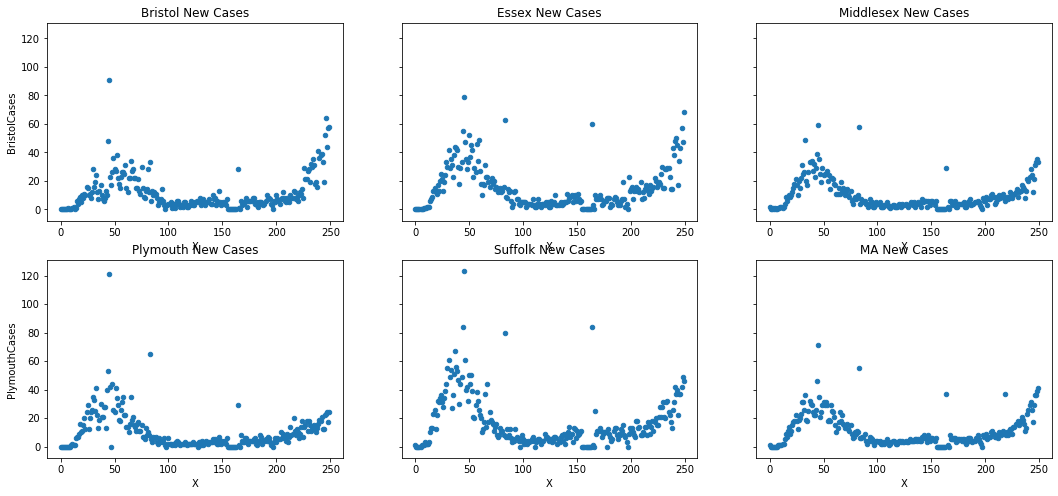

In [19]:
#Scatter plot of the new cases dataframe

fig, axs = plt.subplots(2, 3, sharey=True)
ax1 = dailyTrendsCases.plot(kind='scatter', x="X", y="BristolCases", ax=axs[0,0], figsize=(18, 8))
ax2 = dailyTrendsCases.plot(kind='scatter', x='X', y='EssexCases', ax=axs[0,1])
ax3 = dailyTrendsCases.plot(kind='scatter', x='X', y='MiddlesexCases', ax=axs[0,2])
ax4 = dailyTrendsCases.plot(kind='scatter', x='X', y='PlymouthCases', ax=axs[1,0])
ax5 = dailyTrendsCases.plot(kind='scatter', x='X', y='SuffolkCases', ax=axs[1,1])
ax6 = dailyTrendsCases.plot(kind='scatter', x='X', y='MACases', ax=axs[1,2])
ax1.title.set_text('Bristol New Cases')
ax2.title.set_text('Essex New Cases')
ax3.title.set_text('Middlesex New Cases')
ax4.title.set_text('Plymouth New Cases')
ax5.title.set_text('Suffolk New Cases')
ax6.title.set_text('MA New Cases')

## Linear Regression New Cases

### Fit Linear Regression Model and Print Slope, Intercept and R^2 (new cases)

In [20]:
# create a linear Regression fitted model 
lmBristol = smf.ols(formula='BristolCases ~ X', data=dailyTrendsCases).fit()
lmEssex = smf.ols(formula='EssexCases ~ X', data=dailyTrendsCases).fit()
lmMiddlesex = smf.ols(formula='MiddlesexCases ~ X', data=dailyTrendsCases).fit()
lmPlymouth = smf.ols(formula='PlymouthCases ~ X', data=dailyTrendsCases).fit()
lmSuffolk = smf.ols(formula='SuffolkCases ~ X', data=dailyTrendsCases).fit()
lmMA = smf.ols(formula='MACases ~ X', data=dailyTrendsCases).fit()

# print the slope
print("Slop:")
print(" Bristol\t",lmBristol.params[1],"\n","Essex\t\t",lmEssex.params[1],
      "\n","Middlesex\t",lmMiddlesex.params[1],"\n","Plymouth\t",lmPlymouth.params[1],"\n",
     "Suffolk\t",lmSuffolk.params[1],"\n","MA\t\t",lmMA.params[1],"\n\n")

# print the Intercept
print("Intercept:")
print(" Bristol\t",lmBristol.params[0],"\n","Essex\t\t",lmEssex.params[0],
      "\n","Middlesex\t",lmMiddlesex.params[0],"\n","Plymouth\t",lmPlymouth.params[0],"\n",
     "Suffolk\t",lmSuffolk.params[0],"\n","MA\t\t",lmMA.params[0],"\n")

# print the R^2
print("R squared:")
print(" Bristol\t",lmBristol.rsquared,"\n","Essex\t\t",lmEssex.rsquared,
      "\n","Middlesex\t",lmMiddlesex.rsquared,"\n","Plymouth\t",lmPlymouth.rsquared,"\n",
     "Suffolk\t",lmSuffolk.rsquared,"\n","MA\t\t",lmMA.rsquared,"\n")

Slop:
 Bristol	 0.02107694523112366 
 Essex		 -0.004320453127250053 
 Middlesex	 -0.021999711995391903 
 Plymouth	 -0.03727893246291944 
 Suffolk	 -0.0400629770076321 
 MA		 -0.01349858397734363 


Intercept:
 Bristol	 8.939920318725102 
 Essex		 15.373896414342624 
 Middlesex	 12.634964143426293 
 Plymouth	 14.877227091633468 
 Suffolk	 21.703840637450206 
 MA		 12.688573705179289 

R squared:
 Bristol	 0.014623137045559509 
 Essex		 0.0004586635681489426 
 Middlesex	 0.02481490076382653 
 Plymouth	 0.044883971998065486 
 Suffolk	 0.026859660044711076 
 MA		 0.00805060199509422 



### Plot Linear Regression for each county and the state (new cases)

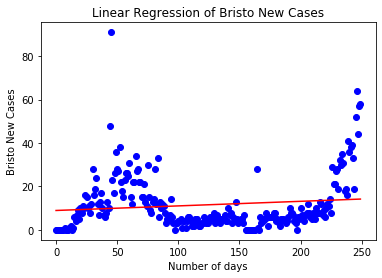

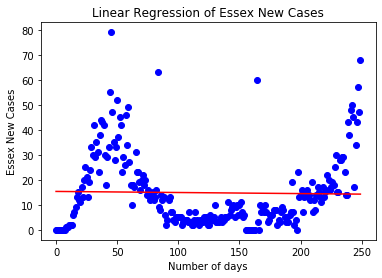

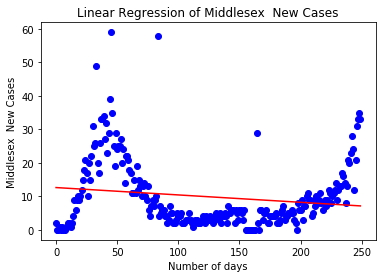

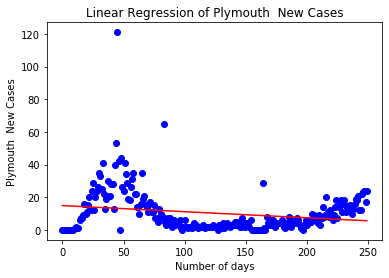

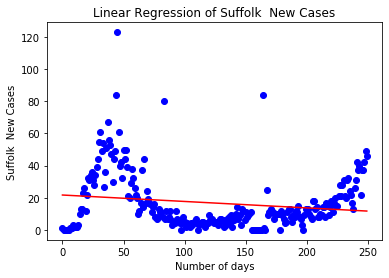

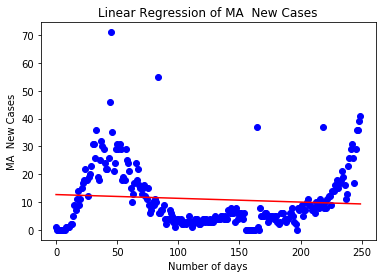

In [21]:
# X is number of days
X = dailyTrendsCases['X'].values.reshape(-1, 1) 

#Plot Bristol linear regression
Y1 = dailyTrendsCases["BristolCases"].values.reshape(-1, 1)
regressor = LinearRegression()
regressor.fit(X,Y1)
y_pred1 = regressor.predict(X)
plt.scatter(X,Y1,color = 'blue')
plt.plot(X,y_pred1,color = 'red')
plt.title('Linear Regression of Bristo New Cases')
plt.xlabel('Number of days')
plt.ylabel('Bristo New Cases')
plt.show()

#Plot Essex linear regression
Y2 = dailyTrendsCases["EssexCases"].values.reshape(-1, 1)
regressor = LinearRegression()
regressor.fit(X,Y2)
y_pred2 = regressor.predict(X)
plt.scatter(X,Y2,color = 'blue')
plt.plot(X,y_pred2,color = 'red')
plt.title('Linear Regression of Essex New Cases')
plt.xlabel('Number of days')
plt.ylabel('Essex New Cases')
plt.show()

#Plot Middlesex linear regression
Y3 = dailyTrendsCases["MiddlesexCases"].values.reshape(-1, 1)
regressor = LinearRegression()
regressor.fit(X,Y3)
y_pred3 = regressor.predict(X)
plt.scatter(X,Y3,color = 'blue')
plt.plot(X,y_pred3,color = 'red')
plt.title('Linear Regression of Middlesex  New Cases')
plt.xlabel('Number of days')
plt.ylabel('Middlesex  New Cases')
plt.show()

#Plot Plymouth linear regression
Y4 = dailyTrendsCases["PlymouthCases"].values.reshape(-1, 1)
regressor = LinearRegression()
regressor.fit(X,Y4)
y_pred4 = regressor.predict(X)
plt.scatter(X,Y4,color = 'blue')
plt.plot(X,y_pred4,color = 'red')
plt.title('Linear Regression of Plymouth  New Cases')
plt.xlabel('Number of days')
plt.ylabel('Plymouth  New Cases')
plt.show()

#Plot Suffolk linear regression
Y5 = dailyTrendsCases["SuffolkCases"].values.reshape(-1, 1)
regressor = LinearRegression()
regressor.fit(X,Y5)
y_pred5 = regressor.predict(X)
plt.scatter(X,Y5,color = 'blue')
plt.plot(X,y_pred5,color = 'red')
plt.title('Linear Regression of Suffolk  New Cases')
plt.xlabel('Number of days')
plt.ylabel('Suffolk  New Cases')
plt.show()

#Plot MA linear regression
Y6 = dailyTrendsCases["MACases"].values.reshape(-1, 1)
regressor = LinearRegression()
regressor.fit(X,Y6)
y_pred6 = regressor.predict(X)
plt.scatter(X,Y6,color = 'blue')
plt.plot(X,y_pred6,color = 'red')
plt.title('Linear Regression of MA  New Cases')
plt.xlabel('Number of days')
plt.ylabel('MA  New Cases')
plt.show()

## Non-Linear Regression New Cases

### Fit Non-Linear Regression Model and Print RMSE and R^2 (new cases)

In [94]:
#Fit polynomial regression from n=2 upto n=10 for each county and the state and calculate R^2 and RMSE for each one

#poly n=2
poly2RSquared=[]
poly2RMSE=[]
for i in range (len(dailyTrendsCases.columns)-1):
    poly_2 = smf.ols(formula='dailyTrendsCases[dailyTrendsCases.columns[i]] ~ 1 + X + I(X ** 2.0)',
                     data=dailyTrendsCases).fit()
    poly2RSquared.append("{:.2f}".format(poly_2.rsquared))
    poly2RMSE.append("{:.2f}".format(np.sqrt(mean_squared_error(dailyTrendsCases[dailyTrendsCases.columns[i]].fillna(0), poly_2.predict(dailyTrendsCases.X)))))
    
#poly n=3
poly3RSquared=[]
poly3RMSE=[]
for i in range (len(dailyTrendsCases.columns)-1):
    poly_3 = smf.ols(formula='dailyTrendsCases[dailyTrendsCases.columns[i]] ~ 1 + X + I(X ** 2.0)+ I(X ** 3.0)',
                     data=dailyTrendsCases).fit()
    poly3RSquared.append( "{:.2f}".format(poly_3.rsquared))
    poly3RMSE.append("{:.2f}".format(np.sqrt(mean_squared_error(dailyTrendsCases[dailyTrendsCases.columns[i]].fillna(0), poly_3.predict(dailyTrendsCases.X)))))
    
#poly n=4
poly4RSquared=[]
poly4RMSE=[]
for i in range (len(dailyTrendsCases.columns)-1):
    poly_4 = smf.ols(formula='dailyTrendsCases[dailyTrendsCases.columns[i]] ~ 1 + X + I(X ** 2.0)+ I(X ** 3.0)+ I(X ** 4.0)'
                     ,data=dailyTrendsCases).fit()
    poly4RSquared.append("{:.2f}".format(poly_4.rsquared))
    poly4RMSE.append("{:.2f}".format(np.sqrt(mean_squared_error(dailyTrendsCases[dailyTrendsCases.columns[i]].fillna(0), poly_4.predict(dailyTrendsCases.X)))))
    
#poly n=5
poly5RSquared=[]
poly5RMSE=[]
for i in range (len(dailyTrendsCases.columns)-1):
    poly_5 = smf.ols(formula='dailyTrendsCases[dailyTrendsCases.columns[i]] ~ 1 + X + I(X ** 2.0)+ I(X ** 3.0)+ I(X ** 4.0)+ I(X ** 5.0)'
                     ,data=dailyTrendsCases).fit()
    poly5RSquared.append("{:.2f}".format(poly_5.rsquared))
    poly5RMSE.append("{:.2f}".format(np.sqrt(mean_squared_error(dailyTrendsCases[dailyTrendsCases.columns[i]].fillna(0), poly_5.predict(dailyTrendsCases.X)))))
     
#poly n=6    
poly6RSquared=[]
poly6RMSE=[]
for i in range (len(dailyTrendsCases.columns)-1):
    poly_6 = smf.ols(formula='dailyTrendsCases[dailyTrendsCases.columns[i]] ~ 1 + X + I(X ** 2.0)+ I(X ** 3.0)+ I(X ** 4.0)+ I(X ** 5.0)+ I(X ** 6.0)'
                     ,data=dailyTrendsCases).fit()
    poly6RSquared.append("{:.2f}".format(poly_6.rsquared))
    poly6RMSE.append("{:.2f}".format(np.sqrt(mean_squared_error(dailyTrendsCases[dailyTrendsCases.columns[i]].fillna(0), poly_6.predict(dailyTrendsCases.X)))))
    
#poly n=7    
poly7RSquared=[]
poly7RMSE=[]
for i in range (len(dailyTrendsCases.columns)-1):
    poly_7 = smf.ols(formula='dailyTrendsCases[dailyTrendsCases.columns[i]] ~ 1 + X + I(X ** 2.0)+ I(X ** 3.0)+ I(X ** 4.0)+ I(X ** 5.0)+ I(X ** 6.0)+ I(X ** 7.0)'
                     ,data=dailyTrendsCases).fit()
    poly7RSquared.append("{:.2f}".format(poly_7.rsquared))
    poly7RMSE.append("{:.2f}".format(np.sqrt(mean_squared_error(dailyTrendsCases[dailyTrendsCases.columns[i]].fillna(0), poly_7.predict(dailyTrendsCases.X)))))
     
#poly n=8   
poly8RSquared=[]
poly8RMSE=[]
for i in range (len(dailyTrendsCases.columns)-1):
    poly_8 = smf.ols(formula='dailyTrendsCases[dailyTrendsCases.columns[i]] ~ 1 + X + I(X ** 2.0)+ I(X ** 3.0)+ I(X ** 4.0)+ I(X ** 5.0)+ I(X ** 6.0)+ I(X ** 7.0)+ I(X ** 8.0)'
                     ,data=dailyTrendsCases).fit()
    poly8RSquared.append("{:.2f}".format(poly_8.rsquared))
    poly8RMSE.append("{:.2f}".format(np.sqrt(mean_squared_error(dailyTrendsCases[dailyTrendsCases.columns[i]].fillna(0), poly_8.predict(dailyTrendsCases.X)))))
    
#poly n=9    
poly9RSquared=[]
poly9RMSE=[]
for i in range (len(dailyTrendsCases.columns)-1):
    poly_9 = smf.ols(formula='dailyTrendsCases[dailyTrendsCases.columns[i]] ~ 1 + X + I(X ** 2.0)+ I(X ** 3.0)+ I(X ** 4.0)+ I(X ** 5.0)+ I(X ** 6.0)+ I(X ** 7.0)+ I(X ** 8.0)+ I(X ** 9.0)'
                     ,data=dailyTrendsCases).fit()
    poly9RSquared.append("{:.2f}".format(poly_9.rsquared))
    poly9RMSE.append("{:.2f}".format(np.sqrt(mean_squared_error(dailyTrendsCases[dailyTrendsCases.columns[i]].fillna(0), poly_9.predict(dailyTrendsCases.X)))))
     
#poly n=10
poly10RSquared=[]
poly10RMSE=[]
for i in range (len(dailyTrendsCases.columns)-1):
    poly_10 = smf.ols(formula='dailyTrendsCases[dailyTrendsCases.columns[i]] ~ 1 + X + I(X ** 2.0)+ I(X ** 3.0)+ I(X ** 4.0)+ I(X ** 5.0)+ I(X ** 6.0)+ I(X ** 7.0)+ I(X ** 8.0)+ I(X ** 9.0)+ I(X ** 10.0)'
                     ,data=dailyTrendsCases).fit()
    poly10RSquared.append("{:.2f}".format(poly_10.rsquared))
    poly10RMSE.append("{:.2f}".format(np.sqrt(mean_squared_error(dailyTrendsCases[dailyTrendsCases.columns[i]].fillna(0), poly_9.predict(dailyTrendsCases.X)))))
     


In [95]:
#Define a dataframe and add R^2 and RMSE of each polynomial as a column to the dataframe
statCountieCases = pd.DataFrame() 

statCountieCases["Location"] = ["MA","Bristol","Essex","Middlesex","Plymouth","Suffolk"]
statCountieCases["poly2RSquared"] = poly2RSquared
statCountieCases["poly2RMSE"] = poly2RMSE
statCountieCases["poly3RSquared"] = poly3RSquared
statCountieCases["poly3RMSE"] = poly3RMSE
statCountieCases["poly4RSquared"] = poly4RSquared
statCountieCases["poly4RMSE"] = poly4RMSE
statCountieCases["poly5RSquared"] = poly5RSquared
statCountieCases["poly5RMSE"] = poly5RMSE
statCountieCases["poly6RSquared"] = poly6RSquared
statCountieCases["poly6RMSE"] = poly6RMSE
statCountieCases["poly7RSquared"] = poly7RSquared
statCountieCases["poly7RMSE"] = poly7RMSE
statCountieCases["poly8RSquared"] = poly8RSquared
statCountieCases["poly8RMSE"] = poly8RMSE
statCountieCases["poly9RSquared"] = poly9RSquared
statCountieCases["poly9RMSE"] = poly9RMSE
statCountieCases["poly10RSquared"] = poly10RSquared
statCountieCases["poly10RMSE"] = poly10RMSE
statCountieCases

,Location,poly2RSquared,poly2RMSE,poly3RSquared,poly3RMSE,poly4RSquared,poly4RMSE,poly5RSquared,poly5RMSE,poly6RSquared,poly6RMSE,poly7RSquared,poly7RMSE,poly8RSquared,poly8RMSE,poly9RSquared,poly9RMSE,poly10RSquared,poly10RMSE
0,MA,0.15,10.00,0.47,7.90,0.55,7.25,0.66,6.38,0.66,6.30,0.68,6.10,0.46,8.00,-0.28,12.30,-0.35,12.72
1,Bristol,0.15,11.60,0.57,8.26,0.58,8.20,0.62,7.77,0.66,7.36,0.67,7.24,0.63,7.65,0.13,11.74,0.06,12.07
2,Essex,0.15,13.45,0.49,10.42,0.56,9.62,0.65,8.64,0.67,8.41,0.69,8.13,0.51,10.18,-0.20,15.97,-0.28,16.07
3,Middlesex,0.15,9.29,0.44,7.58,0.53,6.88,0.65,5.95,0.66,5.89,0.68,5.74,0.41,7.74,-0.34,11.66,-0.41,12.54
4,Plymouth,0.12,11.94,0.31,10.56,0.45,9.41,0.50,8.95,0.51,8.93,0.54,8.61,0.36,10.19,-0.32,14.61,-0.38,15.60
5,Suffolk,0.14,16.32,0.33,14.46,0.45,13.07,0.59,11.31,0.59,11.30,0.61,11.05,0.31,14.60,-0.40,20.91,-0.45,20.91


## Plot Non-Linear Regression (new cases)

In [96]:
#define X variable for plotting
X = dailyTrendsCases['X'].values.reshape(-1, 1) 

#define Xx which contains value of one more week

XWeek2 = [[250],
         [251],
         [252],
         [253],
         [254],
         [255],
         [256]]
Xx = np.append(X,XWeek2)
Xx = Xx.reshape(-1, 1)

In [97]:
# Xx

Text(0, 0.5, 'MA New Cases')

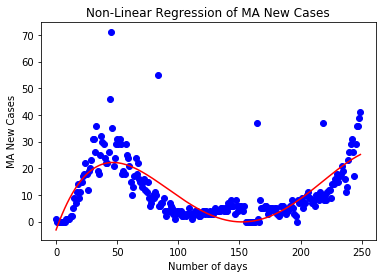

In [98]:
#Plot non-linear regression for MA new cases
Y = dailyTrendsCases["MACases"].values.reshape(-1, 1)
poly_reg=PolynomialFeatures(degree=4)
X_poly=poly_reg.fit_transform(X)

model = sm.OLS(Y, X_poly).fit()
ypred = model.predict(X_poly) 

plt.scatter(X,Y, color = 'blue')
plt.plot(X,ypred,'Red')
plt.title('Non-Linear Regression of MA New Cases')
plt.xlabel('Number of days')
plt.ylabel('MA New Cases')

Text(0, 0.5, 'MA New Cases')

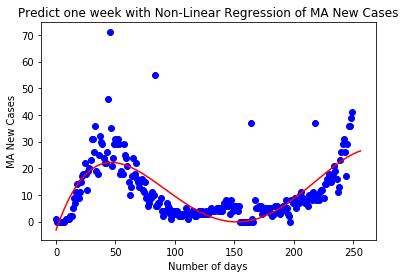

In [99]:
#Plot non-linear regression for MA new cases Predict one week
Y = dailyTrendsCases["MACases"].values.reshape(-1, 1)
X_poly1=poly_reg.fit_transform(Xx)
ypred1 = model.predict(X_poly1) 

plt.scatter(X,Y, color = 'blue')
plt.plot(Xx,ypred1,'Red')
plt.title('Predict one week with Non-Linear Regression of MA New Cases')
plt.xlabel('Number of days')
plt.ylabel('MA New Cases')

In [32]:
# #Plot confidence interval for MA cases

# # Y = dailyTrendsCases["MACases"].values.reshape(-1, 1)
# plt.scatter(X,Y, color = 'blue')
# plt.plot(X,ypred,"Red")
# plt.plot(X,upper,'--',label="Upper") # confid. intrvl
# plt.plot(x,lower,':',label="lower")
# plt.legend(loc='upper right')
# plt.title('Confidence interval of MA New Cases')
# plt.xlabel('Number of days')
# plt.ylabel('MA New Cases')

Text(0, 0.5, 'Bristol New Cases')

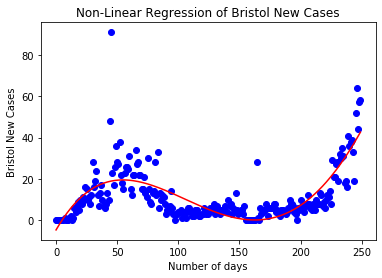

In [41]:
#Plot non-linear regression for Bristol new cases
Y = dailyTrendsCases["BristolCases"].values.reshape(-1, 1)
poly_reg=PolynomialFeatures(degree=4)
X_poly=poly_reg.fit_transform(X)

model = sm.OLS(Y, X_poly).fit()
ypred = model.predict(X_poly) 

plt.scatter(X,Y, color = 'blue')
plt.plot(X,ypred,'Red')
plt.title('Non-Linear Regression of Bristol New Cases')
plt.xlabel('Number of days')
plt.ylabel('Bristol New Cases')

Text(0, 0.5, 'Bristol New Cases')

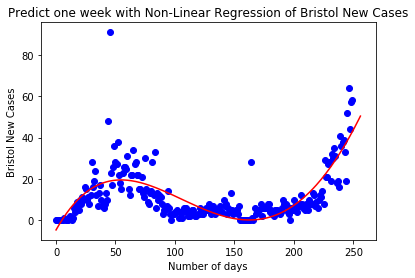

In [42]:
#Plot non-linear regression for Bristol new cases Predict one week
Y = dailyTrendsCases["BristolCases"].values.reshape(-1, 1)
X_poly1=poly_reg.fit_transform(Xx)
ypred1 = model.predict(X_poly1) 

plt.scatter(X,Y, color = 'blue')
plt.plot(Xx,ypred1,'Red')
plt.title('Predict one week with Non-Linear Regression of Bristol New Cases')
plt.xlabel('Number of days')
plt.ylabel('Bristol New Cases')

In [43]:
# #Plot confidence interval for Bristol cases

# Y = dailyTrendsCases["BristolCases"].values.reshape(-1, 1)
# plt.scatter(X,Y, color = 'blue')
# plt.plot(X,ypred,"Red")
# plt.plot(X,upper,'--',label="Upper") # confid. intrvl
# plt.plot(x,lower,':',label="lower")
# plt.legend(loc='upper right')
# plt.title('Confidence interval of Bristol New Cases')
# plt.xlabel('Number of days')
# plt.ylabel('Bristol New Cases')

Text(0, 0.5, 'Essex New Cases')

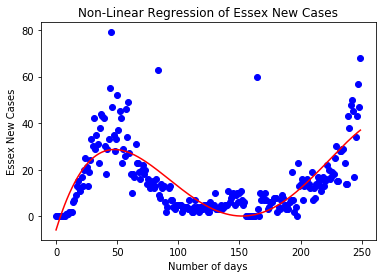

In [44]:
#Plot non-linear regression for Essex new cases
Y = dailyTrendsCases["EssexCases"].values.reshape(-1, 1)
poly_reg=PolynomialFeatures(degree=4)
X_poly=poly_reg.fit_transform(X)

model = sm.OLS(Y, X_poly).fit()
ypred = model.predict(X_poly) 

plt.scatter(X,Y, color = 'blue')
plt.plot(X,ypred,'Red')
plt.title('Non-Linear Regression of Essex New Cases')
plt.xlabel('Number of days')
plt.ylabel('Essex New Cases')

Text(0, 0.5, 'Essex New Cases')

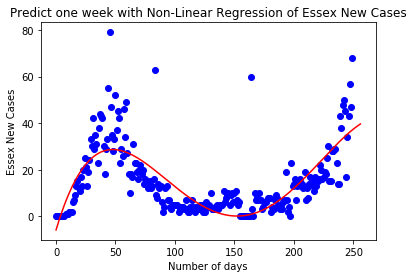

In [45]:
#Plot non-linear regression for Essex new cases Predict one week
Y = dailyTrendsCases["EssexCases"].values.reshape(-1, 1)
X_poly1=poly_reg.fit_transform(Xx)
ypred1 = model.predict(X_poly1) 

plt.scatter(X,Y, color = 'blue')
plt.plot(Xx,ypred1,'Red')
plt.title('Predict one week with Non-Linear Regression of Essex New Cases')
plt.xlabel('Number of days')
plt.ylabel('Essex New Cases')

In [46]:
# #Plot confidence interval for Essex cases

# Y = dailyTrendsCases["EssexCases"].values.reshape(-1, 1)
# plt.scatter(X,Y, color = 'blue')
# plt.plot(X,ypred,"Red")
# plt.plot(X,upper,'--',label="Upper") # confid. intrvl
# plt.plot(x,lower,':',label="lower")
# plt.legend(loc='upper right')
# plt.title('Confidence interval of Essex New Cases')
# plt.xlabel('Number of days')
# plt.ylabel('Essex New Cases')

Text(0, 0.5, 'Middlesex New Cases')

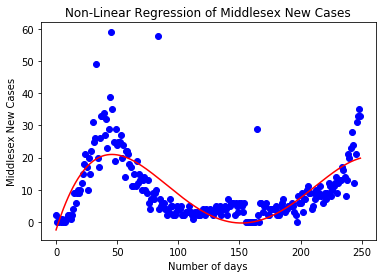

In [47]:
#Plot non-linear regression for Middlesex new cases
Y = dailyTrendsCases["MiddlesexCases"].values.reshape(-1, 1)
poly_reg=PolynomialFeatures(degree=4)
X_poly=poly_reg.fit_transform(X)

model = sm.OLS(Y, X_poly).fit()
ypred = model.predict(X_poly) 

plt.scatter(X,Y, color = 'blue')
plt.plot(X,ypred,'Red')
plt.title('Non-Linear Regression of Middlesex New Cases')
plt.xlabel('Number of days')
plt.ylabel('Middlesex New Cases')

Text(0, 0.5, 'Middlesex New Cases')

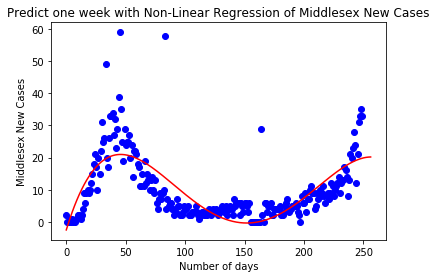

In [48]:
#Plot non-linear regression for Middlesex new cases Predict one week
Y = dailyTrendsCases["MiddlesexCases"].values.reshape(-1, 1)
X_poly1=poly_reg.fit_transform(Xx)
ypred1 = model.predict(X_poly1) 

plt.scatter(X,Y, color = 'blue')
plt.plot(Xx,ypred1,'Red')
plt.title('Predict one week with Non-Linear Regression of Middlesex New Cases')
plt.xlabel('Number of days')
plt.ylabel('Middlesex New Cases')

In [49]:
# #Plot confidence interval for Middlesex cases

# Y = dailyTrendsCases["MiddlesexCases"].values.reshape(-1, 1)
# plt.scatter(X,Y, color = 'blue')
# plt.plot(X,ypred,"Red")
# plt.plot(X,upper,'--',label="Upper") # confid. intrvl
# plt.plot(x,lower,':',label="lower")
# plt.legend(loc='upper right')
# plt.title('Confidence interval of Middlesex New Cases')
# plt.xlabel('Number of days')
# plt.ylabel('Middlesex New Cases')

Text(0, 0.5, 'Plymouth New Cases')

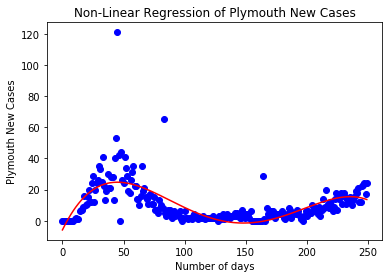

In [50]:
#Plot non-linear regression for Plymouth new cases
Y = dailyTrendsCases["PlymouthCases"].values.reshape(-1, 1)
poly_reg=PolynomialFeatures(degree=4)
X_poly=poly_reg.fit_transform(X)

model = sm.OLS(Y, X_poly).fit()
ypred = model.predict(X_poly) 

plt.scatter(X,Y, color = 'blue')
plt.plot(X,ypred,'Red')
plt.title('Non-Linear Regression of Plymouth New Cases')
plt.xlabel('Number of days')
plt.ylabel('Plymouth New Cases')

Text(0, 0.5, 'Plymouth New Cases')

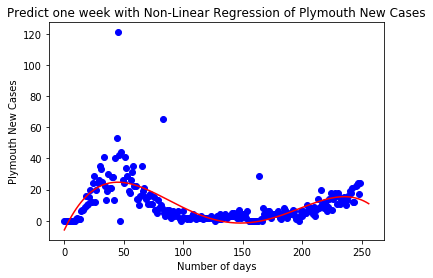

In [51]:
#Plot non-linear regression for Plymouth new cases Predict one week
Y = dailyTrendsCases["PlymouthCases"].values.reshape(-1, 1)
X_poly1=poly_reg.fit_transform(Xx)
ypred1 = model.predict(X_poly1) 

plt.scatter(X,Y, color = 'blue')
plt.plot(Xx,ypred1,'Red')
plt.title('Predict one week with Non-Linear Regression of Plymouth New Cases')
plt.xlabel('Number of days')
plt.ylabel('Plymouth New Cases')

In [52]:
# #Plot confidence interval for Plymouth cases

# Y = dailyTrendsCases["PlymouthCases"].values.reshape(-1, 1)
# plt.scatter(X,Y, color = 'blue')
# plt.plot(X,ypred,"Red")
# plt.plot(X,upper,'--',label="Upper") # confid. intrvl
# plt.plot(x,lower,':',label="lower")
# plt.legend(loc='upper right')
# plt.title('Confidence interval of Plymouth New Cases')
# plt.xlabel('Number of days')
# plt.ylabel('Plymouth New Cases')

Text(0, 0.5, 'Suffolk New Cases')

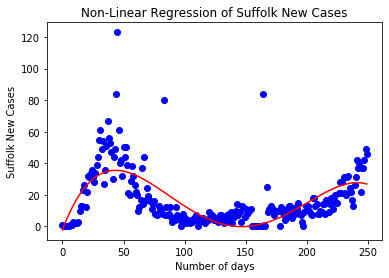

In [53]:
#Plot non-linear regression for Suffolk new cases
Y = dailyTrendsCases["SuffolkCases"].values.reshape(-1, 1)
poly_reg=PolynomialFeatures(degree=4)
X_poly=poly_reg.fit_transform(X)

model = sm.OLS(Y, X_poly).fit()
ypred = model.predict(X_poly) 

plt.scatter(X,Y, color = 'blue')
plt.plot(X,ypred,'Red')
plt.title('Non-Linear Regression of Suffolk New Cases')
plt.xlabel('Number of days')
plt.ylabel('Suffolk New Cases')

Text(0, 0.5, 'Suffolk New Cases')

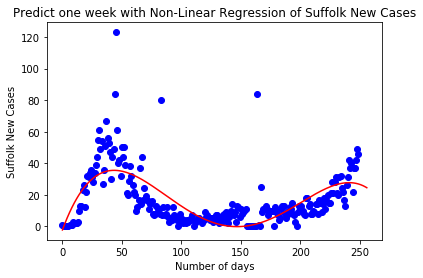

In [54]:
#Plot non-linear regression for Suffolk new cases Predict one week
Y = dailyTrendsCases["SuffolkCases"].values.reshape(-1, 1)
X_poly1=poly_reg.fit_transform(Xx)
ypred1 = model.predict(X_poly1) 

plt.scatter(X,Y, color = 'blue')
plt.plot(Xx,ypred1,'Red')
plt.title('Predict one week with Non-Linear Regression of Suffolk New Cases')
plt.xlabel('Number of days')
plt.ylabel('Suffolk New Cases')

In [55]:
# #Plot confidence interval for Suffolk cases

# Y = dailyTrendsCases["SuffolkCases"].values.reshape(-1, 1)
# plt.scatter(X,Y, color = 'blue')
# plt.plot(X,ypred,"Red")
# plt.plot(X,upper,'--',label="Upper") # confid. intrvl
# plt.plot(x,lower,':',label="lower")
# plt.legend(loc='upper right')
# plt.title('Confidence interval of Suffolk New Cases')
# plt.xlabel('Number of days')
# plt.ylabel('Suffolk New Cases')

#### Compare Polynomial Regression 

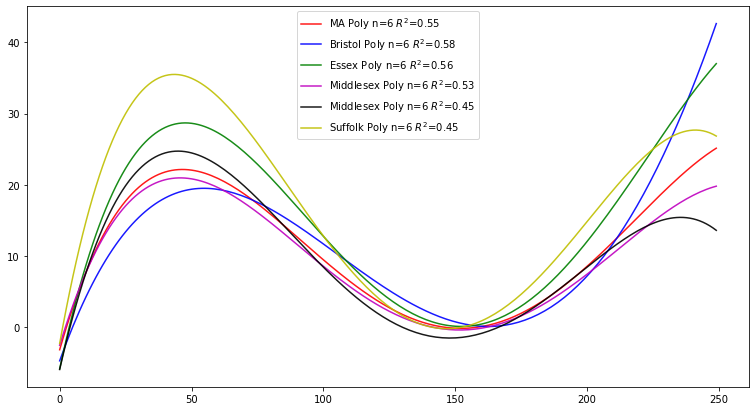

In [56]:

plt.figure(figsize=(8 * 1.618, 7))


x = pd.DataFrame({'X': np.linspace(dailyTrendsCases.X.min(), dailyTrendsCases.X.max(), 200)})

# 6-rd order polynomial
poly_6MA = smf.ols(formula='MACases ~ 1 + X + I(X ** 2.0) + I(X ** 3.0) + I(X ** 4.0)', data=dailyTrendsCases).fit()
plt.plot(x.X, poly_6MA.predict(x), 'r-', alpha=0.9, label='MA Poly n=6 $R^2$=%.2f' % poly_6MA.rsquared)

# 6-rd order polynomial
poly_6Bristol = smf.ols(formula='BristolCases ~ 1 + X + I(X ** 2.0) + I(X ** 3.0) + I(X ** 4.0)', data=dailyTrendsCases).fit()
plt.plot(x.X, poly_6Bristol.predict(x), 'b-', alpha=0.9, label='Bristol Poly n=6 $R^2$=%.2f' % poly_6Bristol.rsquared)

# 6-rd order polynomial
poly_6Essex = smf.ols(formula='EssexCases ~ 1 + X + I(X ** 2.0) + I(X ** 3.0) + I(X ** 4.0)', data=dailyTrendsCases).fit()
plt.plot(x.X, poly_6Essex.predict(x), 'g-', alpha=0.9, label='Essex Poly n=6 $R^2$=%.2f' % poly_6Essex.rsquared)

# 6-rd order polynomial
poly_6Middlesex = smf.ols(formula='MiddlesexCases ~ 1 + X + I(X ** 2.0) + I(X ** 3.0) + I(X ** 4.0)', data=dailyTrendsCases).fit()
plt.plot(x.X, poly_6Middlesex.predict(x), 'm-', alpha=0.9, label='Middlesex Poly n=6 $R^2$=%.2f' % poly_6Middlesex.rsquared)


# 6-rd order polynomial
poly_6Plymouth = smf.ols(formula='PlymouthCases ~ 1 + X + I(X ** 2.0) + I(X ** 3.0) + I(X ** 4.0)', data=dailyTrendsCases).fit()
plt.plot(x.X, poly_6Plymouth.predict(x), 'k-', alpha=0.9, label='Middlesex Poly n=6 $R^2$=%.2f' % poly_6Plymouth.rsquared)


# 6-rd order polynomial
poly_6Suffolk = smf.ols(formula='SuffolkCases ~ 1 + X + I(X ** 2.0) + I(X ** 3.0) + I(X ** 4.0)', data=dailyTrendsCases).fit()
plt.plot(x.X, poly_6Suffolk.predict(x), 'y-', alpha=0.9, label='Suffolk Poly n=6 $R^2$=%.2f' % poly_6Suffolk.rsquared)


plt.legend()

#### We can see that Bristol is in more at risk because the slop of the last days are higher than the other counties

In [69]:
#Confidence interval of MA
poly_6MA.conf_int()

,0,1
Intercept,-7.596851e+00,1.307528e+00
X,1.032395e+00,1.530017e+00
I(X ** 2.0),-2.445598e-02,-1.630549e-02
I(X ** 3.0),8.067428e-05,1.299023e-04
I(X ** 4.0),-2.187944e-07,-1.207241e-07


In [70]:
#Confidence interval of Bristol
poly_6Bristol.conf_int()

,0,1
Intercept,-9.732319e+00,3.412698e-01
X,7.470548e-01,1.310018e+00
I(X ** 2.0),-1.810753e-02,-8.886820e-03
I(X ** 3.0),2.593159e-05,8.162364e-05
I(X ** 4.0),-1.080670e-07,2.880585e-09


In [71]:
#Confidence interval of Essex
poly_6Essex.conf_int()

,0,1
Intercept,-1.173805e+01,8.814018e-02
X,1.380481e+00,2.041389e+00
I(X ** 2.0),-3.210966e-02,-2.128473e-02
I(X ** 3.0),1.033166e-04,1.686980e-04
I(X ** 4.0),-2.804287e-07,-1.501785e-07


In [72]:
#Confidence interval of Middlesex
poly_6Middlesex.conf_int()

,0,1
Intercept,-6.748254e+00,1.707663e+00
X,9.745812e-01,1.447141e+00
I(X ** 2.0),-2.346899e-02,-1.572899e-02
I(X ** 3.0),7.964955e-05,1.263983e-04
I(X ** 4.0),-2.168323e-07,-1.237013e-07


In [73]:
#Confidence interval of Plymouth
poly_6Plymouth.conf_int()

,0,1
Intercept,-1.169479e+01,-1.369157e-01
X,1.292921e+00,1.938834e+00
I(X ** 2.0),-3.217805e-02,-2.159872e-02
I(X ** 3.0),1.155380e-04,1.794360e-04
I(X ** 4.0),-3.218749e-07,-1.945799e-07


In [74]:
#Confidence interval of Suffolk
poly_6Suffolk.conf_int()

,0,1
Intercept,-1.030343e+01,5.758470e+00
X,1.595142e+00,2.492763e+00
I(X ** 2.0),-4.206004e-02,-2.735802e-02
I(X ** 3.0),1.465981e-04,2.353967e-04
I(X ** 4.0),-4.205158e-07,-2.436147e-07


#### #### Compare Linear Regression 

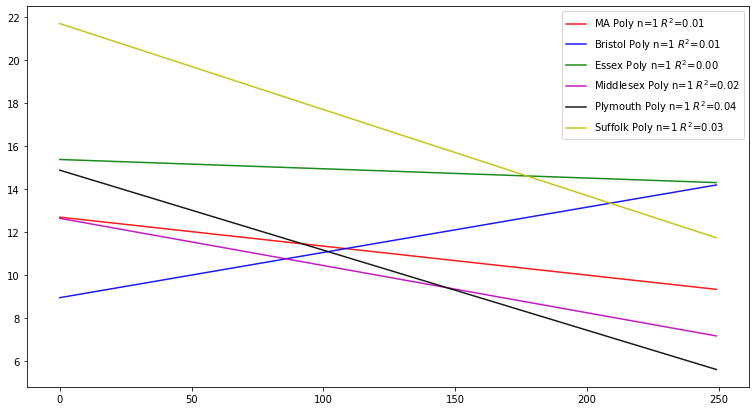

In [75]:

plt.figure(figsize=(8 * 1.618, 7))


x = pd.DataFrame({'X': np.linspace(dailyTrendsCases.X.min(), dailyTrendsCases.X.max(), 200)})

# 1-rd order polynomial
poly_1MA = smf.ols(formula='MACases ~ 1 + X', data=dailyTrendsCases).fit()
plt.plot(x.X, poly_1MA.predict(x), 'r-', alpha=0.9, label='MA Poly n=1 $R^2$=%.2f' % poly_1MA.rsquared)

# 1-rd order polynomial
poly_1Bristol = smf.ols(formula='BristolCases ~ 1 + X', data=dailyTrendsCases).fit()
plt.plot(x.X, poly_1Bristol.predict(x), 'b-', alpha=0.9, label='Bristol Poly n=1 $R^2$=%.2f' % poly_1Bristol.rsquared)

# 1-rd order polynomial
poly_1Essex = smf.ols(formula='EssexCases ~ 1 + X', data=dailyTrendsCases).fit()
plt.plot(x.X, poly_1Essex.predict(x), 'g-', alpha=0.9, label='Essex Poly n=1 $R^2$=%.2f' % poly_1Essex.rsquared)

# 1-rd order polynomial
poly_1Middlesex = smf.ols(formula='MiddlesexCases ~ 1 + X', data=dailyTrendsCases).fit()
plt.plot(x.X, poly_1Middlesex.predict(x), 'm-', alpha=0.9, label='Middlesex Poly n=1 $R^2$=%.2f' % poly_1Middlesex.rsquared)

# 1-rd order polynomial
poly_1Plymouth = smf.ols(formula='PlymouthCases ~ 1 + X', data=dailyTrendsCases).fit()
plt.plot(x.X, poly_1Plymouth.predict(x), 'k-', alpha=0.9, label='Plymouth Poly n=1 $R^2$=%.2f' % poly_1Plymouth.rsquared)

# 1-rd order polynomial
poly_1Suffolk = smf.ols(formula='SuffolkCases ~ 1 + X', data=dailyTrendsCases).fit()
plt.plot(x.X, poly_1Suffolk.predict(x), 'y-', alpha=0.9, label='Suffolk Poly n=1 $R^2$=%.2f' % poly_1Suffolk.rsquared)


plt.legend()

##### Bristol is more at risk because it is more slope.

In [76]:
#Confidence interval of MA
poly_1MA.conf_int()

,0,1
Intercept,9.991828,15.385319
X,-0.032238,0.005241


In [77]:
#Confidence interval of Bristol
poly_1Bristol.conf_int()

,0,1
Intercept,5.825984,12.053857
X,-0.000562,0.042716


In [78]:
#Confidence interval of Essex
poly_1Essex.conf_int()

,0,1
Intercept,11.743921,19.003872
X,-0.029545,0.020904


In [79]:
#Confidence interval of Middlesex
poly_1Middlesex.conf_int()

,0,1
Intercept,10.152829,15.117099
X,-0.039248,-0.004751


In [80]:
#Confidence interval of Plymouth
poly_1Plymouth.conf_int()

,0,1
Intercept,11.782182,17.972273
X,-0.058787,-0.015771


In [81]:
#Confidence interval of Suffolk
poly_1Suffolk.conf_int()

,0,1
Intercept,17.363720,26.043962
X,-0.070223,-0.009903


## New Deaths

In [82]:
#Transpose counties deaths and MA Deaths

TMANewDeaths = MANewDeaths.transpose()

TCountieNewDeaths = CountiesNewDeaths.transpose()

In [83]:
#Concatenate two MADeaths dataframe with countiesDeaths dataframe

dailyTrendsDeaths = pd.concat([TMANewDeaths, TCountieNewDeaths], axis=1)
dailyTrendsDeaths.columns = ['MA','Essex County', 'Hampden County','Norfolk County','Plymouth County'
                         ,'Suffolk County']
dailyTrendsDeaths.head()

,MA,Essex County,Hampden County,Norfolk County,Plymouth County,Suffolk County
1/22/20_y,NaN,NaN,NaN,NaN,NaN,NaN
1/23/20_y,0.0,0.0,0.0,0.0,0.0,0.0
1/24/20_y,0.0,0.0,0.0,0.0,0.0,0.0
1/25/20_y,0.0,0.0,0.0,0.0,0.0,0.0
1/26/20_y,0.0,0.0,0.0,0.0,0.0,0.0


In [84]:
# Normalize new deaths

dailyTrendsDeaths["MADeaths"] = ((dailyTrendsDeaths["MA"]/6892503)*100000).round()
dailyTrendsDeaths["EssexDeaths"] = ((dailyTrendsDeaths["Essex County"]/789034)*100000).round()
dailyTrendsDeaths["HampdenDeaths"] = ((dailyTrendsDeaths["Hampden County"]/466372)*100000).round()
dailyTrendsDeaths["NorfolkDeaths"] = ((dailyTrendsDeaths["Norfolk County"]/706775)*100000).round()
dailyTrendsDeaths["PlymouthDeaths"] = ((dailyTrendsDeaths["Plymouth County"]/521202)*100000).round()
dailyTrendsDeaths["SuffolkDeaths"] = ((dailyTrendsDeaths["Suffolk County"]/803907)*100000).round()

#Drop unnecessary columns 
dailyTrendsDeaths.drop(columns =["MA","Essex County", "Hampden County", "Norfolk County", "Plymouth County",
                               "Suffolk County"], inplace = True)
dailyTrendsDeaths.head()

,MADeaths,EssexDeaths,HampdenDeaths,NorfolkDeaths,PlymouthDeaths,SuffolkDeaths
1/22/20_y,NaN,NaN,NaN,NaN,NaN,NaN
1/23/20_y,0.0,0.0,0.0,0.0,0.0,0.0
1/24/20_y,0.0,0.0,0.0,0.0,0.0,0.0
1/25/20_y,0.0,0.0,0.0,0.0,0.0,0.0
1/26/20_y,0.0,0.0,0.0,0.0,0.0,0.0


In [85]:
#Ignore the rows before fisrt day of infection

dailyTrendsDeaths.drop(dailyTrendsDeaths.index[0:65],0, inplace = True)
dailyTrendsDeaths.head()

,MADeaths,EssexDeaths,HampdenDeaths,NorfolkDeaths,PlymouthDeaths,SuffolkDeaths
3/27/20_y,0.0,0.0,0.0,1.0,0.0,0.0
3/28/20_y,0.0,0.0,1.0,0.0,0.0,0.0
3/29/20_y,0.0,0.0,0.0,0.0,0.0,0.0
3/30/20_y,0.0,0.0,0.0,0.0,0.0,0.0
3/31/20_y,0.0,1.0,2.0,0.0,0.0,0.0


In [86]:
#add a column to datafram which shows number of days
# x = dailyTrendsDeaths.index
dailyTrendsDeaths["X"] = range(0,len(dailyTrendsDeaths))
dailyTrendsDeaths.head()

,MADeaths,EssexDeaths,HampdenDeaths,NorfolkDeaths,PlymouthDeaths,SuffolkDeaths,X
3/27/20_y,0.0,0.0,0.0,1.0,0.0,0.0,0
3/28/20_y,0.0,0.0,1.0,0.0,0.0,0.0,1
3/29/20_y,0.0,0.0,0.0,0.0,0.0,0.0,2
3/30/20_y,0.0,0.0,0.0,0.0,0.0,0.0,3
3/31/20_y,0.0,1.0,2.0,0.0,0.0,0.0,4


### Scatter Plot of New Deaths

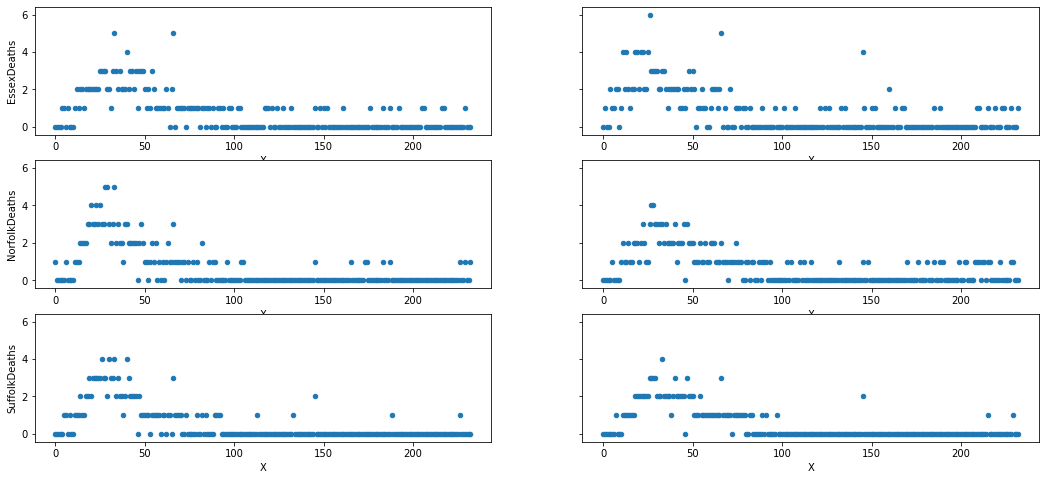

In [89]:
fig, axs = plt.subplots(3, 2, sharey=True)
dailyTrendsDeaths.plot(kind='scatter', x="X", y="EssexDeaths", ax=axs[0,0], figsize=(18, 8))
dailyTrendsDeaths.plot(kind='scatter', x='X', y='HampdenDeaths', ax=axs[0,1])
dailyTrendsDeaths.plot(kind='scatter', x='X', y='NorfolkDeaths', ax=axs[1,0])
dailyTrendsDeaths.plot(kind='scatter', x='X', y='PlymouthDeaths', ax=axs[1,1])
dailyTrendsDeaths.plot(kind='scatter', x='X', y='SuffolkDeaths', ax=axs[2,0])
dailyTrendsDeaths.plot(kind='scatter', x='X', y='MADeaths', ax=axs[2,1])

In [90]:
# create a fitted model in one line
lmEssex = smf.ols(formula='EssexDeaths ~ X', data=dailyTrendsDeaths).fit()
lmHampden = smf.ols(formula='EssexDeaths ~ X', data=dailyTrendsDeaths).fit()
lmNorfolk = smf.ols(formula='NorfolkDeaths ~ X', data=dailyTrendsDeaths).fit()
lmPlymouth = smf.ols(formula='PlymouthDeaths ~ X', data=dailyTrendsDeaths).fit()
lmSuffolk = smf.ols(formula='SuffolkDeaths ~ X', data=dailyTrendsDeaths).fit()
lmMA = smf.ols(formula='MADeaths ~ X', data=dailyTrendsDeaths).fit()

# print the slope
print("Slope: ")
print(" Essex\t\t",lmEssex.params[1],"\n","Hampden\t",lmHampden.params[1],
      "\n","Norfolk\t",lmNorfolk.params[1],"\n","Plymouth\t",lmPlymouth.params[1],"\n",
     "Suffolk\t",lmSuffolk.params[1],"\n","MA\t\t",lmMA.params[1],"\n\n")

# print the Intercept
print("Intercept: ")
print(" Essex\t\t",lmEssex.params[0],"\n","Hampden\t",lmHampden.params[0],
      "\n","Middlesex\t",lmNorfolk.params[0],"\n","Plymouth\t",lmPlymouth.params[0],"\n",
     "Suffolk\t",lmSuffolk.params[0],"\n","MA\t\t",lmMA.params[0],"\n")

# print the R^2
print("R squared: ")
print(" Essex\t\t",lmEssex.rsquared,"\n","Hampden\t",lmHampden.rsquared,
      "\n","Norfolk\t",lmNorfolk.rsquared,"\n","Plymouth\t",lmPlymouth.rsquared,"\n",
     "Suffolk\t",lmSuffolk.rsquared,"\n","MA\t\t",lmMA.rsquared,"\n")

Slope: 
 Essex		 -0.008882526382896369 
 Hampden	 -0.008882526382896369 
 Norfolk	 -0.009266743320317392 
 Plymouth	 -0.007245098150825543 
 Suffolk	 -0.008490719975106536 
 MA		 -0.007728926886837202 


Intercept: 
 Essex		 1.7428194123473084 
 Hampden	 1.7428194123473084 
 Middlesex	 1.6972598217233403 
 Plymouth	 1.5056674369979082 
 Suffolk	 1.5171123583140744 
 MA		 1.4072851326070204 

R squared: 
 Essex		 0.3588904882741172 
 Hampden	 0.3588904882741172 
 Norfolk	 0.3318530518836965 
 Plymouth	 0.2944876375494574 
 Suffolk	 0.3550882981727984 
 MA		 0.38342680304896526 



## Plot Linear Regression New Deaths

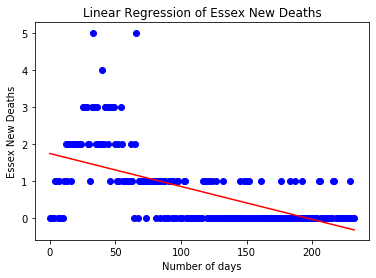

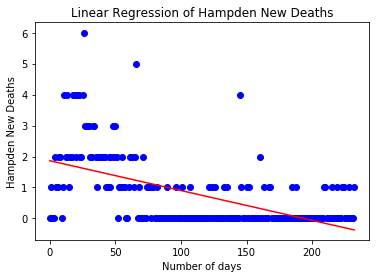

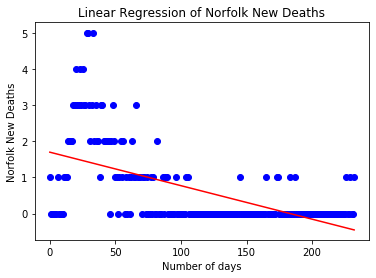

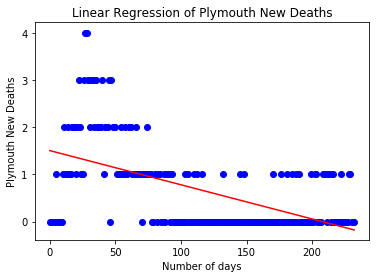

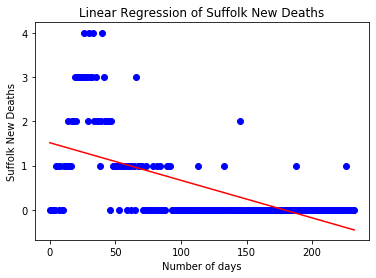

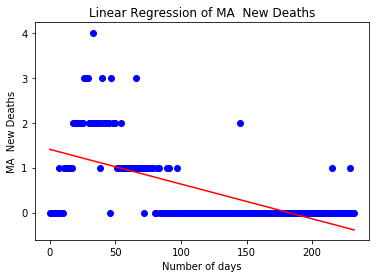

In [91]:
# X is number of days
X = dailyTrendsDeaths['X'].values.reshape(-1, 1) 

#Plot Essex linear regression
Y1 = dailyTrendsDeaths["EssexDeaths"].values.reshape(-1, 1)
regressor = LinearRegression()
regressor.fit(X,Y1)
y_pred1 = regressor.predict(X)
plt.scatter(X,Y1,color = 'blue')
plt.plot(X,y_pred1,color = 'red')
plt.title('Linear Regression of Essex New Deaths')
plt.xlabel('Number of days')
plt.ylabel('Essex New Deaths')
plt.show()

#Plot Hampden linear regression
Y2 = dailyTrendsDeaths["HampdenDeaths"].values.reshape(-1, 1)
regressor = LinearRegression()
regressor.fit(X,Y2)
y_pred2 = regressor.predict(X)
plt.scatter(X,Y2,color = 'blue')
plt.plot(X,y_pred2,color = 'red')
plt.title('Linear Regression of Hampden New Deaths')
plt.xlabel('Number of days')
plt.ylabel('Hampden New Deaths')
plt.show()

#Plot Norfolk linear regression
Y3 = dailyTrendsDeaths["NorfolkDeaths"].values.reshape(-1, 1)
regressor = LinearRegression()
regressor.fit(X,Y3)
y_pred3 = regressor.predict(X)
plt.scatter(X,Y3,color = 'blue')
plt.plot(X,y_pred3,color = 'red')
plt.title('Linear Regression of Norfolk New Deaths')
plt.xlabel('Number of days')
plt.ylabel('Norfolk New Deaths')
plt.show()

#Plot Plymouth linear regression
Y4 = dailyTrendsDeaths["PlymouthDeaths"].values.reshape(-1, 1)
regressor = LinearRegression()
regressor.fit(X,Y4)
y_pred4 = regressor.predict(X)
plt.scatter(X,Y4,color = 'blue')
plt.plot(X,y_pred4,color = 'red')
plt.title('Linear Regression of Plymouth New Deaths')
plt.xlabel('Number of days')
plt.ylabel('Plymouth New Deaths')
plt.show()

#Plot Suffolk linear regression
Y5 = dailyTrendsDeaths["SuffolkDeaths"].values.reshape(-1, 1)
regressor = LinearRegression()
regressor.fit(X,Y5)
y_pred5 = regressor.predict(X)
plt.scatter(X,Y5,color = 'blue')
plt.plot(X,y_pred5,color = 'red')
plt.title('Linear Regression of Suffolk New Deaths')
plt.xlabel('Number of days')
plt.ylabel('Suffolk New Deaths')
plt.show()

#Plot MA linear regression
Y6 = dailyTrendsDeaths["MADeaths"].values.reshape(-1, 1)
regressor = LinearRegression()
regressor.fit(X,Y6)
y_pred6 = regressor.predict(X)
plt.scatter(X,Y6,color = 'blue')
plt.plot(X,y_pred6,color = 'red')
plt.title('Linear Regression of MA  New Deaths')
plt.xlabel('Number of days')
plt.ylabel('MA  New Deaths')
plt.show()

## Non-Linear Regression Model New Deaths

### Fit Non-Linear Regression Model and Print RMSE and R^2 (new cases)

In [100]:
# Fit data of new deaths with nonlinear regression from n=2 upto n=10

poly2RSquared=[]
poly2RMSE=[]
for i in range (len(dailyTrendsDeaths.columns)-1):
    poly_2 = smf.ols(formula='dailyTrendsDeaths[dailyTrendsDeaths.columns[i]] ~ 1 + X + I(X ** 2.0)',
                     data=dailyTrendsDeaths).fit()
    poly2RSquared.append("{:.2f}".format(poly_2.rsquared))
    poly2RMSE.append("{:.2f}".format(np.sqrt(mean_squared_error(dailyTrendsDeaths[dailyTrendsDeaths.columns[i]].fillna(0), poly_2.predict(dailyTrendsDeaths.X)))))
    

poly3RSquared=[]
poly3RMSE=[]
for i in range (len(dailyTrendsDeaths.columns)-1):
    poly_3 = smf.ols(formula='dailyTrendsDeaths[dailyTrendsDeaths.columns[i]] ~ 1 + X + I(X ** 2.0)+ I(X ** 3.0)',
                     data=dailyTrendsDeaths).fit()
    poly3RSquared.append( "{:.2f}".format(poly_3.rsquared))
    poly3RMSE.append("{:.2f}".format(np.sqrt(mean_squared_error(dailyTrendsDeaths[dailyTrendsDeaths.columns[i]].fillna(0), poly_3.predict(dailyTrendsDeaths.X)))))
    

poly4RSquared=[]
poly4RMSE=[]
for i in range (len(dailyTrendsDeaths.columns)-1):
    poly_4 = smf.ols(formula='dailyTrendsDeaths[dailyTrendsDeaths.columns[i]] ~ 1 + X + I(X ** 2.0)+ I(X ** 3.0)+ I(X ** 4.0)'
                     ,data=dailyTrendsDeaths).fit()
    poly4RSquared.append("{:.2f}".format(poly_4.rsquared))
    poly4RMSE.append("{:.2f}".format(np.sqrt(mean_squared_error(dailyTrendsDeaths[dailyTrendsDeaths.columns[i]].fillna(0), poly_4.predict(dailyTrendsDeaths.X)))))
    
    
poly5RSquared=[]
poly5RMSE=[]
for i in range (len(dailyTrendsDeaths.columns)-1):
    poly_5 = smf.ols(formula='dailyTrendsDeaths[dailyTrendsDeaths.columns[i]] ~ 1 + X + I(X ** 2.0)+ I(X ** 3.0)+ I(X ** 4.0)+ I(X ** 5.0)'
                     ,data=dailyTrendsDeaths).fit()
    poly5RSquared.append("{:.2f}".format(poly_5.rsquared))
    poly5RMSE.append("{:.2f}".format(np.sqrt(mean_squared_error(dailyTrendsDeaths[dailyTrendsDeaths.columns[i]].fillna(0), poly_5.predict(dailyTrendsDeaths.X)))))
     
    
poly6RSquared=[]
poly6RMSE=[]
for i in range (len(dailyTrendsDeaths.columns)-1):
    poly_6 = smf.ols(formula='dailyTrendsDeaths[dailyTrendsDeaths.columns[i]] ~ 1 + X + I(X ** 2.0)+ I(X ** 3.0)+ I(X ** 4.0)+ I(X ** 5.0)+ I(X ** 6.0)'
                     ,data=dailyTrendsDeaths).fit()
    poly6RSquared.append("{:.2f}".format(poly_6.rsquared))
    poly6RMSE.append("{:.2f}".format(np.sqrt(mean_squared_error(dailyTrendsDeaths[dailyTrendsDeaths.columns[i]].fillna(0), poly_6.predict(dailyTrendsDeaths.X)))))
    
    
poly7RSquared=[]
poly7RMSE=[]
for i in range (len(dailyTrendsDeaths.columns)-1):
    poly_7 = smf.ols(formula='dailyTrendsDeaths[dailyTrendsDeaths.columns[i]] ~ 1 + X + I(X ** 2.0)+ I(X ** 3.0)+ I(X ** 4.0)+ I(X ** 5.0)+ I(X ** 6.0)+ I(X ** 7.0)'
                     ,data=dailyTrendsDeaths).fit()
    poly7RSquared.append("{:.2f}".format(poly_7.rsquared))
    poly7RMSE.append("{:.2f}".format(np.sqrt(mean_squared_error(dailyTrendsDeaths[dailyTrendsDeaths.columns[i]].fillna(0), poly_7.predict(dailyTrendsDeaths.X)))))
     
    
poly8RSquared=[]
poly8RMSE=[]
for i in range (len(dailyTrendsDeaths.columns)-1):
    poly_8 = smf.ols(formula='dailyTrendsDeaths[dailyTrendsDeaths.columns[i]] ~ 1 + X + I(X ** 2.0)+ I(X ** 3.0)+ I(X ** 4.0)+ I(X ** 5.0)+ I(X ** 6.0)+ I(X ** 7.0)+ I(X ** 8.0)'
                     ,data=dailyTrendsDeaths).fit()
    poly8RSquared.append("{:.2f}".format(poly_8.rsquared))
    poly8RMSE.append("{:.2f}".format(np.sqrt(mean_squared_error(dailyTrendsDeaths[dailyTrendsDeaths.columns[i]].fillna(0), poly_8.predict(dailyTrendsDeaths.X)))))
    
    
poly9RSquared=[]
poly9RMSE=[]
for i in range (len(dailyTrendsDeaths.columns)-1):
    poly_9 = smf.ols(formula='dailyTrendsDeaths[dailyTrendsDeaths.columns[i]] ~ 1 + X + I(X ** 2.0)+ I(X ** 3.0)+ I(X ** 4.0)+ I(X ** 5.0)+ I(X ** 6.0)+ I(X ** 7.0)+ I(X ** 8.0)+ I(X ** 9.0)'
                     ,data=dailyTrendsDeaths).fit()
    poly9RSquared.append("{:.2f}".format(poly_9.rsquared))
    poly9RMSE.append("{:.2f}".format(np.sqrt(mean_squared_error(dailyTrendsDeaths[dailyTrendsDeaths.columns[i]].fillna(0), poly_9.predict(dailyTrendsDeaths.X)))))
     

poly10RSquared=[]
poly10RMSE=[]
for i in range (len(dailyTrendsDeaths.columns)-1):
    poly_10 = smf.ols(formula='dailyTrendsDeaths[dailyTrendsDeaths.columns[i]] ~ 1 + X + I(X ** 2.0)+ I(X ** 3.0)+ I(X ** 4.0)+ I(X ** 5.0)+ I(X ** 6.0)+ I(X ** 7.0)+ I(X ** 8.0)+ I(X ** 9.0)+ I(X ** 10.0)'
                     ,data=dailyTrendsDeaths).fit()
    poly10RSquared.append("{:.2f}".format(poly_10.rsquared))
    poly10RMSE.append("{:.2f}".format(np.sqrt(mean_squared_error(dailyTrendsDeaths[dailyTrendsDeaths.columns[i]].fillna(0), poly_9.predict(dailyTrendsDeaths.X)))))
     


In [101]:
#define a dataframe to show the R^2 and RMSE of different poly of each county and the state 
statCountieDeaths = pd.DataFrame() 

statCountieDeaths["Location"] = ["MA","Essex","Hampden","Norfolk","Plymouth","Suffolk"]
statCountieDeaths["poly2RSquared"] = poly2RSquared
statCountieDeaths["poly2RMSE"] = poly2RMSE
statCountieDeaths["poly3RSquared"] = poly3RSquared
statCountieDeaths["poly3RMSE"] = poly3RMSE
statCountieDeaths["poly4RSquared"] = poly4RSquared
statCountieDeaths["poly4RMSE"] = poly4RMSE
statCountieDeaths["poly5RSquared"] = poly5RSquared
statCountieDeaths["poly5RMSE"] = poly5RMSE
statCountieDeaths["poly6RSquared"] = poly6RSquared
statCountieDeaths["poly6RMSE"] = poly6RMSE
statCountieDeaths["poly7RSquared"] = poly7RSquared
statCountieDeaths["poly7RMSE"] = poly7RMSE
statCountieDeaths["poly8RSquared"] = poly8RSquared
statCountieDeaths["poly8RMSE"] = poly8RMSE
statCountieDeaths["poly9RSquared"] = poly9RSquared
statCountieDeaths["poly9RMSE"] = poly9RMSE
statCountieDeaths["poly10RSquared"] = poly10RSquared
statCountieDeaths["poly10RMSE"] = poly10RMSE
statCountieDeaths

,Location,poly2RSquared,poly2RMSE,poly3RSquared,poly3RMSE,poly4RSquared,poly4RMSE,poly5RSquared,poly5RMSE,poly6RSquared,poly6RMSE,poly7RSquared,poly7RMSE,poly8RSquared,poly8RMSE,poly9RSquared,poly9RMSE,poly10RSquared,poly10RMSE
0,MA,0.42,0.64,0.51,0.59,0.69,0.47,0.77,0.40,0.78,0.40,0.73,0.44,0.42,0.64,0.07,0.81,-0.34,0.81
1,Essex,0.38,0.79,0.45,0.74,0.60,0.63,0.66,0.58,0.67,0.58,0.62,0.61,0.31,0.83,-0.02,1.01,-0.43,1.04
2,Hampden,0.42,0.86,0.42,0.86,0.49,0.81,0.58,0.73,0.60,0.72,0.42,0.86,0.09,1.08,-0.16,1.22,-0.40,1.23
3,Norfolk,0.40,0.84,0.43,0.82,0.56,0.72,0.69,0.61,0.70,0.59,0.56,0.72,0.19,0.97,-0.07,1.12,-0.31,1.13
4,Plymouth,0.34,0.73,0.43,0.68,0.62,0.56,0.66,0.52,0.67,0.51,0.61,0.56,0.28,0.76,-0.05,0.92,-0.45,0.94
5,Suffolk,0.42,0.73,0.44,0.72,0.58,0.62,0.70,0.53,0.73,0.50,0.60,0.61,0.20,0.86,-0.08,0.99,-0.29,0.99


## Plot Non-Linear Regression (new deaths)

In [107]:
#define X variable for plotting
XD = dailyTrendsDeaths['X'].values.reshape(-1, 1) 

#define Xx which contains value of one more week

XWeek2D = [[233],
         [234],
         [235],
         [236],
         [237],
         [238],
         [239]]
XxD = np.append(XD,XWeek2D)
XxD = XxD.reshape(-1, 1)

Text(0, 0.5, 'MA New Deaths')

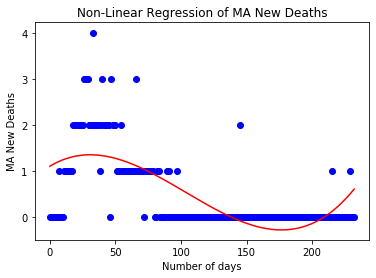

In [115]:
#Plot non-linear regression for MA new Deaths
YD = dailyTrendsDeaths["MADeaths"].values.reshape(-1, 1)

polynomial_features= PolynomialFeatures(degree=3)
x_poly = polynomial_features.fit_transform(XD)

model = LinearRegression()
model.fit(x_poly, YD)
y_poly_pred = model.predict(x_poly)

plt.scatter(XD,YD, color = 'blue')
plt.plot(XD,y_poly_pred,'Red')
plt.title('Non-Linear Regression of MA New Deaths')
plt.xlabel('Number of days')
plt.ylabel('MA New Deaths')

Text(0, 0.5, 'MA New Deaths')

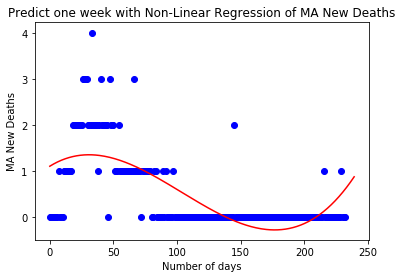

In [116]:
YD = dailyTrendsDeaths["MADeaths"].values.reshape(-1, 1)
x_poly = polynomial_features.fit_transform(XxD)
y_poly_pred = model.predict(x_poly)

plt.scatter(XD,YD, color = 'blue')
plt.plot(XxD,y_poly_pred,'Red')
plt.title('Predict one week with Non-Linear Regression of MA New Deaths')
plt.xlabel('Number of days')
plt.ylabel('MA New Deaths')

In [111]:
# #Plot confidence interval for MA Deaths

# YD = dailyTrendsDeaths["MADeaths"].values.reshape(-1, 1)
# plt.scatter(XD,YD, color = 'blue')
# plt.plot(XD,ypredD,"Red")
# plt.plot(XD,upper,'--',label="Upper") # confid. intrvl
# plt.plot(xD,lower,':',label="lower")
# plt.legend(loc='upper right')
# plt.title('Confidence interval of Hampden New Cases')
# plt.xlabel('Number of days')
# plt.ylabel('Hampden New Cases')

Text(0, 0.5, 'Essex New Deaths')

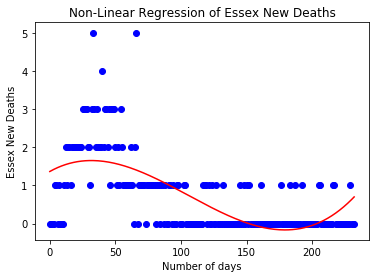

In [112]:
#Plot non-linear regression for Essex new Deaths
YD = dailyTrendsDeaths["EssexDeaths"].values.reshape(-1, 1)

polynomial_features= PolynomialFeatures(degree=3)
x_poly = polynomial_features.fit_transform(XD)

model = LinearRegression()
model.fit(x_poly, YD)
y_poly_pred = model.predict(x_poly)

plt.scatter(XD,YD, color = 'blue')
plt.plot(XD,y_poly_pred,'Red')

plt.title('Non-Linear Regression of Essex New Deaths')
plt.xlabel('Number of days')
plt.ylabel('Essex New Deaths')

Text(0, 0.5, 'Essex New Deaths')

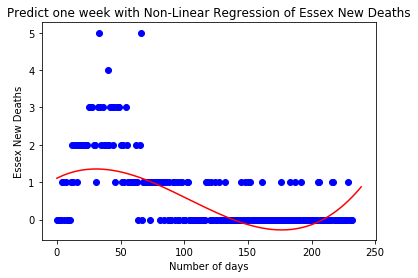

In [118]:
#Plot non-linear regression for Essex new Deaths Predict one week

YD = dailyTrendsDeaths["EssexDeaths"].values.reshape(-1, 1)
x_poly = polynomial_features.fit_transform(XxD)
y_poly_pred = model.predict(x_poly)

plt.scatter(XD,YD, color = 'blue')
plt.plot(XxD,y_poly_pred,'Red')
plt.title('Predict one week with Non-Linear Regression of Essex New Deaths')
plt.xlabel('Number of days')
plt.ylabel('Essex New Deaths')

In [119]:
# #Plot confidence interval for Essex Deaths

# YD = dailyTrendsDeaths["EssexDeaths"].values.reshape(-1, 1)
# plt.scatter(XD,YD, color = 'blue')
# plt.plot(XD,ypredD,"Red")
# plt.plot(XD,upper,'--',label="Upper") # confid. intrvl
# plt.plot(xD,lower,':',label="lower")
# plt.legend(loc='upper right')
# plt.title('Confidence interval of Essex New Deaths')
# plt.xlabel('Number of days')
# plt.ylabel('Essex New Deaths')

Text(0, 0.5, 'Hampden New Cases')

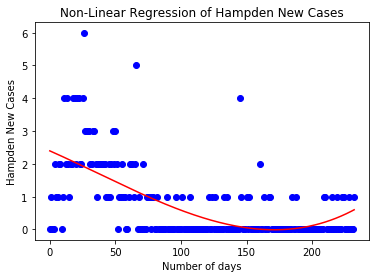

In [120]:
#Plot non-linear regression for Hampden new Deaths
YD = dailyTrendsDeaths["HampdenDeaths"].values.reshape(-1, 1)

polynomial_features= PolynomialFeatures(degree=3)
x_poly = polynomial_features.fit_transform(XD)

model = LinearRegression()
model.fit(x_poly, YD)
y_poly_pred = model.predict(x_poly)

plt.scatter(XD,YD, color = 'blue')
plt.plot(XD,y_poly_pred,'Red')
plt.title('Non-Linear Regression of Hampden New Cases')
plt.xlabel('Number of days')
plt.ylabel('Hampden New Cases')

Text(0, 0.5, 'Hampden New Deaths')

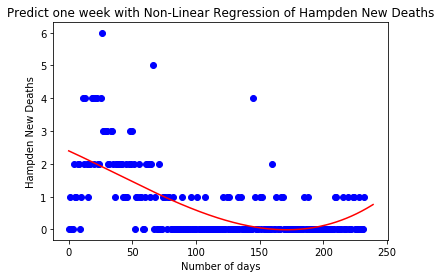

In [123]:
#Plot non-linear regression for Hampden new Deaths Predict one week
YD = dailyTrendsDeaths["HampdenDeaths"].values.reshape(-1, 1)
x_poly = polynomial_features.fit_transform(XxD)
y_poly_pred = model.predict(x_poly)

plt.scatter(XD,YD, color = 'blue')
plt.plot(XxD,y_poly_pred,'Red')
plt.title('Predict one week with Non-Linear Regression of Hampden New Deaths')
plt.xlabel('Number of days')
plt.ylabel('Hampden New Deaths')

In [99]:
# #Plot confidence interval for Hampden Deaths

# YD = dailyTrendsDeaths["HampdenDeaths"].values.reshape(-1, 1)
# plt.scatter(XD,YD, color = 'blue')
# plt.plot(XD,ypredD,"Red")
# plt.plot(XD,upper,'--',label="Upper") # confid. intrvl
# plt.plot(xD,lower,':',label="lower")
# plt.legend(loc='upper right')
# plt.title('Confidence interval of Hampden New Deaths')
# plt.xlabel('Number of days')
# plt.ylabel('Hampden New Deaths')

Text(0, 0.5, 'Norfolk New Cases')

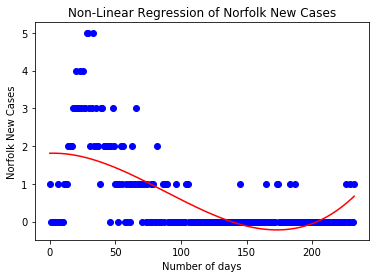

In [124]:
#Plot non-linear regression for Norfolk new Deaths
YD = dailyTrendsDeaths["NorfolkDeaths"].values.reshape(-1, 1)

polynomial_features= PolynomialFeatures(degree=3)
x_poly = polynomial_features.fit_transform(XD)

model = LinearRegression()
model.fit(x_poly, YD)
y_poly_pred = model.predict(x_poly)

plt.scatter(XD,YD, color = 'blue')
plt.plot(XD,y_poly_pred,'Red')
plt.title('Non-Linear Regression of Norfolk New Cases')
plt.xlabel('Number of days')
plt.ylabel('Norfolk New Cases')

Text(0, 0.5, 'Norfolk New Deaths')

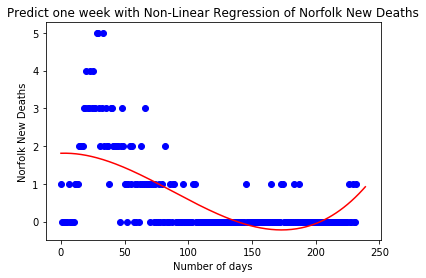

In [125]:
#Plot non-linear regression for Norfolk new Deaths Predict one week

YD = dailyTrendsDeaths["NorfolkDeaths"].values.reshape(-1, 1)
x_poly = polynomial_features.fit_transform(XxD)
y_poly_pred = model.predict(x_poly)

plt.scatter(XD,YD, color = 'blue')
plt.plot(XxD,y_poly_pred,'Red')
plt.title('Predict one week with Non-Linear Regression of Norfolk New Deaths')
plt.xlabel('Number of days')
plt.ylabel('Norfolk New Deaths')

In [126]:
# #Plot confidence interval for Norfolk Deaths

# YD = dailyTrendsDeaths["NorfolkDeaths"].values.reshape(-1, 1)
# plt.scatter(XD,YD, color = 'blue')
# plt.plot(XD,ypredD,"Red")
# plt.plot(XD,upper,'--',label="Upper") # confid. intrvl
# plt.plot(xD,lower,':',label="lower")
# plt.legend(loc='upper right')
# plt.title('Confidence interval of Norfolk New Deaths')
# plt.xlabel('Number of days')
# plt.ylabel('Norfolk New Deaths')

Text(0, 0.5, 'Plymouth New Cases')

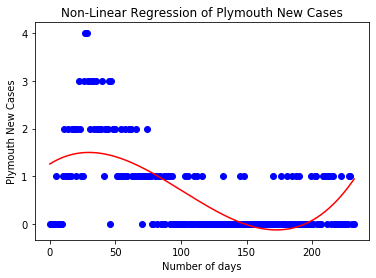

In [127]:
#Plot non-linear regression for Plymouth new Deaths
YD = dailyTrendsDeaths["PlymouthDeaths"].values.reshape(-1, 1)

polynomial_features= PolynomialFeatures(degree=3)
x_poly = polynomial_features.fit_transform(XD)

model = LinearRegression()
model.fit(x_poly, YD)
y_poly_pred = model.predict(x_poly)

plt.scatter(XD,YD, color = 'blue')
plt.plot(XD,y_poly_pred,'Red')
plt.title('Non-Linear Regression of Plymouth New Cases')
plt.xlabel('Number of days')
plt.ylabel('Plymouth New Cases')

Text(0, 0.5, 'Plymouth New Deaths')

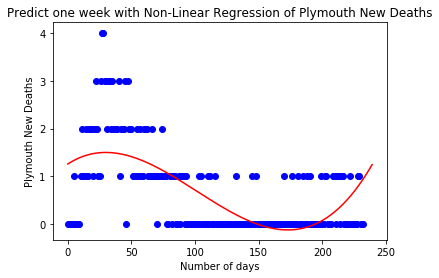

In [128]:
#Plot non-linear regression for Plymouth new Deaths Predict one week

YD = dailyTrendsDeaths["PlymouthDeaths"].values.reshape(-1, 1)
x_poly = polynomial_features.fit_transform(XxD)
y_poly_pred = model.predict(x_poly)

plt.scatter(XD,YD, color = 'blue')
plt.plot(XxD,y_poly_pred,'Red')
plt.title('Predict one week with Non-Linear Regression of Plymouth New Deaths')
plt.xlabel('Number of days')
plt.ylabel('Plymouth New Deaths')

In [129]:
# #Plot confidence interval for Plymouth Deaths

# YD = dailyTrendsDeaths["PlymouthDeaths"].values.reshape(-1, 1)
# plt.scatter(XD,YD, color = 'blue')
# plt.plot(XD,ypredD,"Red")
# plt.plot(XD,upper,'--',label="Upper") # confid. intrvl
# plt.plot(xD,lower,':',label="lower")
# plt.legend(loc='upper right')
# plt.title('Confidence interval of Plymouth New deaths')
# plt.xlabel('Number of days')
# plt.ylabel('Plymouth New deaths')

Text(0, 0.5, 'Suffolk New Cases')

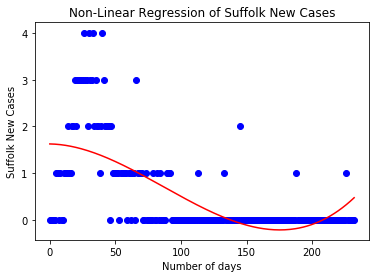

In [130]:
#Plot non-linear regression for Suffolk new Deaths
YD = dailyTrendsDeaths["SuffolkDeaths"].values.reshape(-1, 1)

polynomial_features= PolynomialFeatures(degree=3)
x_poly = polynomial_features.fit_transform(XD)

model = LinearRegression()
model.fit(x_poly, YD)
y_poly_pred = model.predict(x_poly)

plt.scatter(XD,YD, color = 'blue')
plt.plot(XD,y_poly_pred,'Red')
plt.title('Non-Linear Regression of Suffolk New Cases')
plt.xlabel('Number of days')
plt.ylabel('Suffolk New Cases')

Text(0, 0.5, 'Suffolk New Deaths')

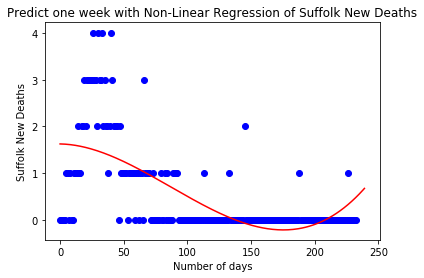

In [131]:
#Plot non-linear regression for Suffolk new Deaths Predict one week
YD = dailyTrendsDeaths["SuffolkDeaths"].values.reshape(-1, 1)
x_poly = polynomial_features.fit_transform(XxD)
y_poly_pred = model.predict(x_poly)

plt.scatter(XD,YD, color = 'blue')
plt.plot(XxD,y_poly_pred,'Red')
plt.title('Predict one week with Non-Linear Regression of Suffolk New Deaths')
plt.xlabel('Number of days')
plt.ylabel('Suffolk New Deaths')

In [132]:
# #Plot confidence interval for Suffolk Deaths

# YD = dailyTrendsDeaths["SuffolkDeaths"].values.reshape(-1, 1)
# plt.scatter(XD,YD, color = 'blue')
# plt.plot(XD,ypredD,"Red")
# plt.plot(XD,upper,'--',label="Upper") # confid. intrvl
# plt.plot(xD,lower,':',label="lower")
# plt.legend(loc='upper right')
# plt.title('Confidence interval of Suffolk New deaths')
# plt.xlabel('Number of days')
# plt.ylabel('Suffolk New deaths')

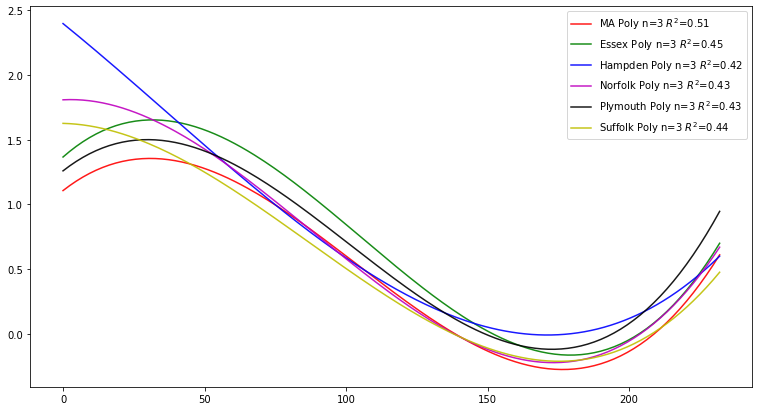

In [133]:

plt.figure(figsize=(8 * 1.618, 7))


x = pd.DataFrame({'X': np.linspace(dailyTrendsDeaths.X.min(), dailyTrendsDeaths.X.max(), 200)})

# 3-rd order polynomial
poly_3MA = smf.ols(formula='MADeaths ~ 1 + X + I(X ** 2.0) + I(X ** 3.0)', data=dailyTrendsDeaths).fit()
plt.plot(x.X, poly_3MA.predict(x), 'r-', alpha=0.9, label='MA Poly n=3 $R^2$=%.2f' % poly_3MA.rsquared)

# 3-rd order polynomial
poly_3Essex = smf.ols(formula='EssexDeaths ~ 1 + X + I(X ** 2.0) + I(X ** 3.0)', data=dailyTrendsDeaths).fit()
plt.plot(x.X, poly_3Essex.predict(x), 'g-', alpha=0.9, label='Essex Poly n=3 $R^2$=%.2f' % poly_3Essex.rsquared)

# 3-rd order polynomial
poly_3Hampden = smf.ols(formula='HampdenDeaths ~ 1 + X + I(X ** 2.0) + I(X ** 3.0)', data=dailyTrendsDeaths).fit()
plt.plot(x.X, poly_3Hampden.predict(x), 'b-', alpha=0.9, label='Hampden Poly n=3 $R^2$=%.2f' % poly_3Hampden.rsquared)

# 3-rd order polynomial
poly_3Norfolk = smf.ols(formula='NorfolkDeaths ~ 1 + X + I(X ** 2.0) + I(X ** 3.0)', data=dailyTrendsDeaths).fit()
plt.plot(x.X, poly_3Norfolk.predict(x), 'm-', alpha=0.9, label='Norfolk Poly n=3 $R^2$=%.2f' % poly_3Norfolk.rsquared)

# 3-rd order polynomial
poly_3Plymouth = smf.ols(formula='PlymouthDeaths ~ 1 + X + I(X ** 2.0) + I(X ** 3.0)', data=dailyTrendsDeaths).fit()
plt.plot(x.X, poly_3Plymouth.predict(x), 'k-', alpha=0.9, label='Plymouth Poly n=3 $R^2$=%.2f' % poly_3Plymouth.rsquared)

# 3-rd order polynomial
poly_3Suffolk = smf.ols(formula='SuffolkDeaths ~ 1 + X + I(X ** 2.0) + I(X ** 3.0)', data=dailyTrendsDeaths).fit()
plt.plot(x.X, poly_3Suffolk.predict(x), 'y-', alpha=0.9, label='Suffolk Poly n=3 $R^2$=%.2f' % poly_3Suffolk.rsquared)


plt.legend()

#### Plymouth is more at risk. The slop in the last days are more than other counties

In [134]:
#Confidence interval of MA
poly_3MA.conf_int()

,0,1
Intercept,8.047773e-01,1.408213
X,5.860279e-03,0.028434
I(X ** 2.0),-4.404281e-04,-0.000214
I(X ** 3.0),7.315237e-07,0.000001


In [135]:
#Confidence interval of Essex
poly_3Essex.conf_int()

,0,1
Intercept,9.880741e-01,1.743771
X,5.118612e-03,0.033389
I(X ** 2.0),-4.995843e-04,-0.000216
I(X ** 3.0),7.297322e-07,0.000002


In [136]:
#Confidence interval of Hampden
poly_3Hampden.conf_int()

,0,1
Intercept,1.957098e+00,2.836678e+00
X,-3.415611e-02,-1.251849e-03
I(X ** 2.0),-2.045317e-04,1.254445e-04
I(X ** 3.0),-1.119281e-07,8.229072e-07


In [137]:
#Confidence interval of Norfolk
poly_3Norfolk.conf_int()

,0,1
Intercept,1.389754e+00,2.226180
X,-1.448217e-02,0.016808
I(X ** 2.0),-3.734012e-04,-0.000060
I(X ** 3.0),3.759524e-07,0.000001


In [138]:
#Confidence interval of Plymouth
poly_3Plymouth.conf_int()

,0,1
Intercept,9.116278e-01,1.606377
X,4.163288e-03,0.030153
I(X ** 2.0),-4.675483e-04,-0.000207
I(X ** 3.0),7.405316e-07,0.000001


In [139]:
#Confidence interval of Suffolk
poly_3Suffolk.conf_int()

,0,1
Intercept,1.259159e+00,1.992577
X,-1.424838e-02,0.013188
I(X ** 2.0),-3.109492e-04,-0.000036
I(X ** 3.0),2.753213e-07,0.000001


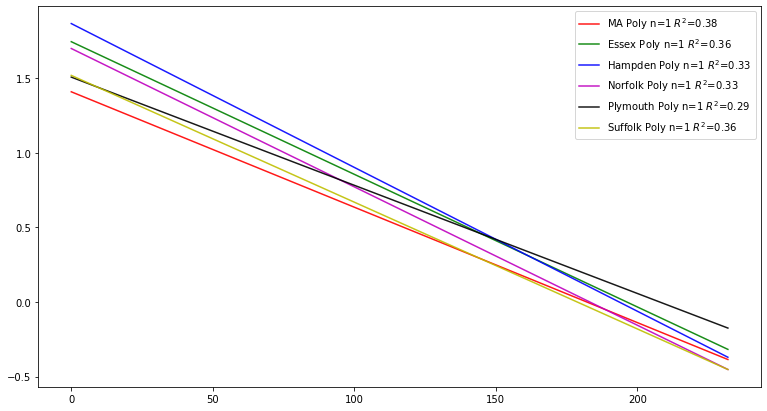

In [140]:

plt.figure(figsize=(8 * 1.618, 7))


x = pd.DataFrame({'X': np.linspace(dailyTrendsDeaths.X.min(), dailyTrendsDeaths.X.max(), 200)})

# 1-rd order polynomial
poly_1MA = smf.ols(formula='MADeaths ~ 1 + X', data=dailyTrendsDeaths).fit()
plt.plot(x.X, poly_1MA.predict(x), 'r-', alpha=0.9, label='MA Poly n=1 $R^2$=%.2f' % poly_1MA.rsquared)

# 1-rd order polynomial
poly_1Essex = smf.ols(formula='EssexDeaths ~ 1 + X', data=dailyTrendsDeaths).fit()
plt.plot(x.X, poly_1Essex.predict(x), 'g-', alpha=0.9, label='Essex Poly n=1 $R^2$=%.2f' % poly_1Essex.rsquared)

# 1-rd order polynomial
poly_1Hampden = smf.ols(formula='HampdenDeaths ~ 1 + X', data=dailyTrendsDeaths).fit()
plt.plot(x.X, poly_1Hampden.predict(x), 'b-', alpha=0.9, label='Hampden Poly n=1 $R^2$=%.2f' % poly_1Hampden.rsquared)

# 1-rd order polynomial
poly_1Norfolk = smf.ols(formula='NorfolkDeaths ~ 1 + X', data=dailyTrendsDeaths).fit()
plt.plot(x.X, poly_1Norfolk.predict(x), 'm-', alpha=0.9, label='Norfolk Poly n=1 $R^2$=%.2f' % poly_1Norfolk.rsquared)

# 1-rd order polynomial
poly_1Plymouth = smf.ols(formula='PlymouthDeaths ~ 1 + X', data=dailyTrendsDeaths).fit()
plt.plot(x.X, poly_1Plymouth.predict(x), 'k-', alpha=0.9, label='Plymouth Poly n=1 $R^2$=%.2f' % poly_1Plymouth.rsquared)

# 1-rd order polynomial
poly_1Suffolk = smf.ols(formula='SuffolkDeaths ~ 1 + X', data=dailyTrendsDeaths).fit()
plt.plot(x.X, poly_1Suffolk.predict(x), 'y-', alpha=0.9, label='Suffolk Poly n=1 $R^2$=%.2f' % poly_1Suffolk.rsquared)


plt.legend()

#### Plymouth's line is higher than others so it is more at risk.

In [141]:
#Confidence interval of MA
poly_1MA.conf_int()

,0,1
Intercept,1.236917,1.577653
X,-0.008999,-0.006458


In [142]:
#Confidence interval of Essex
poly_1Essex.conf_int()

,0,1
Intercept,1.536453,1.949186
X,-0.010422,-0.007344


In [143]:
#Confidence interval of Hampden
poly_1Hampden.conf_int()

,0,1
Intercept,1.624615,2.103788
X,-0.011420,-0.007846


In [144]:
#Confidence interval of Norfolk
poly_1Norfolk.conf_int()

,0,1
Intercept,1.468695,1.925824
X,-0.010971,-0.007562


In [145]:
#Confidence interval of Plymouth
poly_1Plymouth.conf_int()

,0,1
Intercept,1.310736,1.700599
X,-0.008699,-0.005791


In [146]:
#Confidence interval of Suffolk
poly_1Suffolk.conf_int()

,0,1
Intercept,1.318208,1.716017
X,-0.009974,-0.007007


# Utilize the hospital data to calculate the point of no return for a state. Use percentage occupancy / utilization to see which states are close and what their trend looks like.

In [152]:
#Read hospital dataset
# hospital = pd.read_csv("Hospital_Beds.csv")
hospital = pd.read_csv("../../../data/Hospital_Beds.csv", index_col=0)
hospital.head()

,Y,OBJECTID,HOSPITAL_NAME,HOSPITAL_TYPE,HQ_ADDRESS,HQ_ADDRESS1,HQ_CITY,HQ_STATE,HQ_ZIP_CODE,COUNTY_NAME,...,CNTY_FIPS,FIPS,NUM_LICENSED_BEDS,NUM_STAFFED_BEDS,NUM_ICU_BEDS,ADULT_ICU_BEDS,PEDI_ICU_BEDS,BED_UTILIZATION,Potential_Increase_In_Bed_Capac,AVG_VENTILATOR_USAGE
X,,,,,,,,,,,,,,,,,,,,,
-112.066157,33.495498,1,Phoenix VA Health Care System (AKA Carl T Hayd...,VA Hospital,650 E Indian School Rd,NaN,Phoenix,AZ,85012,Maricopa,...,13.0,4013.0,62.0,62.0,0,0,NaN,NaN,0,0
-110.965885,32.181263,2,Southern Arizona VA Health Care System,VA Hospital,3601 S 6th Ave,NaN,Tucson,AZ,85723,Pima,...,19.0,4019.0,295.0,295.0,2,2,NaN,NaN,0,2
-119.779742,36.773323,3,VA Central California Health Care System,VA Hospital,2615 E Clinton Ave,NaN,Fresno,CA,93703,Fresno,...,19.0,6019.0,54.0,54.0,2,2,NaN,NaN,0,2
-72.957610,41.284400,4,VA Connecticut Healthcare System - West Haven ...,VA Hospital,950 Campbell Ave,NaN,West Haven,CT,6516,New Haven,...,9.0,9009.0,216.0,216.0,1,1,NaN,NaN,0,2
-75.606533,39.740206,5,Wilmington VA Medical Center,VA Hospital,1601 Kirkwood Hwy,NaN,Wilmington,DE,19805,New Castle,...,3.0,10003.0,62.0,62.0,0,0,NaN,NaN,0,1


In [153]:
#Groupby state
hospitalState = hospital.groupby("HQ_STATE").sum()
hospitalState.head()

,Y,OBJECTID,HQ_ZIP_CODE,STATE_FIPS,CNTY_FIPS,FIPS,NUM_LICENSED_BEDS,NUM_STAFFED_BEDS,NUM_ICU_BEDS,ADULT_ICU_BEDS,PEDI_ICU_BEDS,BED_UTILIZATION,Potential_Increase_In_Bed_Capac,AVG_VENTILATOR_USAGE
HQ_STATE,,,,,,,,,,,,,,
AK,1708.269904,74109,2790092,56.0,3171.0,59171.0,1832.0,1532.0,193,193,76.0,8.963031,300,41
AL,3940.949991,189711,4311191,120.0,8548.0,128548.0,18611.0,15138.0,1637,1637,569.0,52.147326,3473,383
AR,3752.656395,215151,7736789,535.0,8697.0,543697.0,12729.0,10012.0,914,914,247.0,42.606742,2717,261
AS,-14.290190,4262,96799,0.0,0.0,0.0,120.0,120.0,21,21,0.0,0.000000,0,2
AZ,4252.257966,332286,10857425,508.0,1795.0,509795.0,18345.0,15695.0,1882,1882,532.0,56.815879,2650,427


In [154]:
hospitalState.columns

Index(['Y', 'OBJECTID', 'HQ_ZIP_CODE', 'STATE_FIPS', 'CNTY_FIPS', 'FIPS',
       'NUM_LICENSED_BEDS', 'NUM_STAFFED_BEDS', 'NUM_ICU_BEDS',
       'ADULT_ICU_BEDS', 'PEDI_ICU_BEDS', 'BED_UTILIZATION',
       'Potential_Increase_In_Bed_Capac', 'AVG_VENTILATOR_USAGE'],
      dtype='object')

In [155]:
#Make a dataframe which includes only number of ICU beds

Hospital = hospitalState["NUM_ICU_BEDS"]
Hospital = Hospital.to_frame()
Hospital.head()

,NUM_ICU_BEDS
HQ_STATE,
AK,193
AL,1637
AR,914
AS,21
AZ,1882


In [156]:
#drop some states which are not in covid dataset

Hospital.drop(["AS","GU","MP","PR","VI"], axis = 0, inplace = True)

In [171]:
#define dataframe for new deaths of state
covidDeaths = covid_dfState.filter(regex = "_y")
state = covid_dfState["State"]
# covidDeaths.drop(["countyFIPS"],axis = 1, inplace = True)
NewDeaths = covidDeaths.diff(axis = 1).fillna(0)
NewDeaths.head()

,1/22/20_y,1/23/20_y,1/24/20_y,1/25/20_y,1/26/20_y,1/27/20_y,1/28/20_y,1/29/20_y,1/30/20_y,1/31/20_y,...,11/5/20_y,11/6/20_y,11/7/20_y,11/8/20_y,11/9/20_y,11/10/20_y,11/11/20_y,11/12/20_y,11/13/20_y,11/14/20_y
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,8.0,4.0,0.0,1.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,20.0,25.0,33.0,1.0,0.0,36.0,81.0,12.0,20.0,15.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,11.0,19.0,12.0,17.0,23.0,4.0,14.0,18.0,4.0,11.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,28.0,22.0,38.0,17.0,0.0,26.0,37.0,12.0,18.0,43.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,47.0,75.0,29.0,10.0,29.0,66.0,37.0,33.0,80.0,33.0


In [172]:
#first day of new deaths
date = '2/6/20_y'

#ignore days before first day of new deaths
ignoreColumns = []
for i  in range(15):
    ignoreColumns.append(NewDeaths.columns[i])
    
NewDeaths.drop(ignoreColumns, axis = 1, inplace = True)
NewDeaths.head()

,2/6/20_y,2/7/20_y,2/8/20_y,2/9/20_y,2/10/20_y,2/11/20_y,2/12/20_y,2/13/20_y,2/14/20_y,2/15/20_y,...,11/5/20_y,11/6/20_y,11/7/20_y,11/8/20_y,11/9/20_y,11/10/20_y,11/11/20_y,11/12/20_y,11/13/20_y,11/14/20_y
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,8.0,4.0,0.0,1.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,20.0,25.0,33.0,1.0,0.0,36.0,81.0,12.0,20.0,15.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,11.0,19.0,12.0,17.0,23.0,4.0,14.0,18.0,4.0,11.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,28.0,22.0,38.0,17.0,0.0,26.0,37.0,12.0,18.0,43.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,47.0,75.0,29.0,10.0,29.0,66.0,37.0,33.0,80.0,33.0


In [173]:
#Transpose the dataframe

TNewDeaths = NewDeaths.transpose()
TNewDeaths.columns = state

In [174]:
#Add a column which contains number of days
TNewDeaths["X"] = range(0,len(TNewDeaths))
TNewDeaths.head()

State,AK,AL,AR,AZ,CA,CO,CT,DC,DE,FL,...,TN,TX,UT,VA,VT,WA,WI,WV,WY,X
2/6/20_y,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2/7/20_y,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2/8/20_y,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2/9/20_y,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
2/10/20_y,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [175]:
# fig, axs = plt.subplots(3, 2, sharey=True)
# dailyTrendsDeaths.plot(kind='scatter', x="X", y="EssexDeaths", ax=axs[0,0], figsize=(18, 8))
# dailyTrendsDeaths.plot(kind='scatter', x='X', y='HampdenDeaths', ax=axs[0,1])
# dailyTrendsDeaths.plot(kind='scatter', x='X', y='NorfolkDeaths', ax=axs[1,0])
# dailyTrendsDeaths.plot(kind='scatter', x='X', y='PlymouthDeaths', ax=axs[1,1])
# dailyTrendsDeaths.plot(kind='scatter', x='X', y='SuffolkDeaths', ax=axs[2,0])
# TNewDeaths.plot(kind='scatter', x='X', y='AL')
TNewDeaths.columns

Index(['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI',
       'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN',
       'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH',
       'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA',
       'WI', 'WV', 'WY', 'X'],
      dtype='object', name='State')

In [176]:
#define X variable for plotting
X = TNewDeaths['X'].values.reshape(-1, 1) 

#define Xx which contains value of one more week

XWeek2D = [[217],
         [218],
         [219],
         [220],
         [221],
         [222],
         [223]]
Xx = np.append(XD,XWeek2D)
Xx = Xx.reshape(-1, 1)

In [177]:
#Calculate R^2 for all states for polynomial from n=2 upto n=5

poly2R2 = []
poly3R2 = []
poly4R2 = []
poly5R2 = []

#poly n = 2
for i in range (len(TNewDeaths.columns)-1):
    Y = TNewDeaths[TNewDeaths.columns[i]].values.reshape(-1, 1)
    poly_reg=PolynomialFeatures(degree=2)
    X_poly=poly_reg.fit_transform(X)
    model = sm.OLS(Y, X_poly).fit()
    poly2R2.append(model.rsquared)

#poly n = 3
for i in range (len(TNewDeaths.columns)-1):
    Y = TNewDeaths[TNewDeaths.columns[i]].values.reshape(-1, 1)
    poly_reg=PolynomialFeatures(degree=3)
    X_poly=poly_reg.fit_transform(X)
    model = sm.OLS(Y, X_poly).fit()
    poly3R2.append(model.rsquared)

#poly n = 4
for i in range (len(TNewDeaths.columns)-1):
    Y = TNewDeaths[TNewDeaths.columns[i]].values.reshape(-1, 1)
    poly_reg=PolynomialFeatures(degree=4)
    X_poly=poly_reg.fit_transform(X)
    model = sm.OLS(Y, X_poly).fit()
    poly4R2.append(model.rsquared)

#poly n = 5
for i in range (len(TNewDeaths.columns)-1):
    Y = TNewDeaths[TNewDeaths.columns[i]].values.reshape(-1, 1)
    poly_reg=PolynomialFeatures(degree=5)
    X_poly=poly_reg.fit_transform(X)
    model = sm.OLS(Y, X_poly).fit()
    poly5R2.append(model.rsquared)


In [178]:
#define a dataframe which includes R^2 of states

stateR2 = pd.DataFrame() 
stateR2["State"] = TNewDeaths.columns[:-1]
stateR2["poly2R^2"] = poly2R2
stateR2["poly3R^2"] = poly3R2
stateR2["poly4R^2"] = poly4R2
stateR2["poly5R^2"] = poly5R2

stateR2.head()

,State,poly2R^2,poly3R^2,poly4R^2,poly5R^2
0,AK,0.128521,0.134179,0.134274,0.140635
1,AL,0.221031,0.221357,0.247507,0.258651
2,AR,0.354229,0.364864,0.383319,0.388456
3,AZ,0.228348,0.255024,0.308880,0.365498
4,CA,0.417715,0.446367,0.446647,0.449617


In [179]:
#predict one week for each state by using poly n=5 and add all prediction to the list

prediction = []

for i in range (len(TNewDeaths.columns)-1):
    Y = TNewDeaths[TNewDeaths.columns[i]].values.reshape(-1, 1)
    poly_reg=PolynomialFeatures(degree=6)
    X_poly=poly_reg.fit_transform(X)
    model = sm.OLS(Y, X_poly).fit()
#     ypred = model.predict(poly_reg.fit_transform(XWeek2D)) 
    prediction.append(model.predict(poly_reg.fit_transform(XWeek2D)) )

#### compare predicted 7days of all states with their number of ICU beds to see if number of predicted deaths are close or bigger than ICU beds.

In [ ]:
state_riskRow = []
for i in range (len(Hospital)):
    for j in range (7):
        if (Hospital["NUM_ICU_BEDS"][i] <= prediction[i][j]):
            state_riskRow.append(i)

*There is no point of return for states

In [185]:
state_riskRow

[]

In [186]:
prediction

[array([0.58385688, 0.5857815 , 0.58759728, 0.58931582, 0.59094969,
        0.59251242, 0.59401856]),
 array([15.87234164, 15.68933827, 15.50282117, 15.31310468, 15.12052404,
        14.92543603, 14.72821951]),
 array([16.66740425, 16.85310187, 17.03607787, 17.21613985, 17.393092  ,
        17.56673508, 17.73686648]),
 array([30.72253221, 29.81088108, 28.89206483, 27.96723157, 27.03757353,
        26.10432769, 25.16877645]),
 array([111.50581013, 110.46795023, 109.37093232, 108.2152503 ,
        107.00152196, 105.73049323, 104.40304256]),
 array([4.91401351, 4.95832288, 4.99868399, 5.03506756, 5.06746916,
        5.09591048, 5.12044039]),
 array([5.87275082, 6.04094698, 6.19021334, 6.3199469 , 6.4296038 ,
        6.51870254, 6.58682727]),
 array([0.85281899, 0.874091  , 0.89414592, 0.91289996, 0.93027325,
        0.94619007, 0.96057919]),
 array([0.8795567 , 0.9021447 , 0.92601617, 0.95112235, 0.97741325,
        1.0048377 , 1.03334342]),
 array([131.73847065, 130.66589863, 129.5211042

## Utilize decision tree, random forest, and ARIMA based models to compare and contrast the performance of each. X-variable is the previous weeks data, Y-variable is current week data. So you are predicting one week in advance. Calculate RMSE error. This is just based on number of cases.

### Random Forest

In [188]:
#define X variable for plotting
X = dailyTrendsCases['X'].values.reshape(-1, 1) 

#define Xx which contains value of one more week

XWeek2 = [[283],
         [284],
         [285],
         [286],
         [287],
         [288],
         [289]]
Xx = np.append(X,XWeek2)
Xx = Xx.reshape(-1, 1)

C:\Users\sanam\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


Text(0, 0.5, 'MA New Cases')

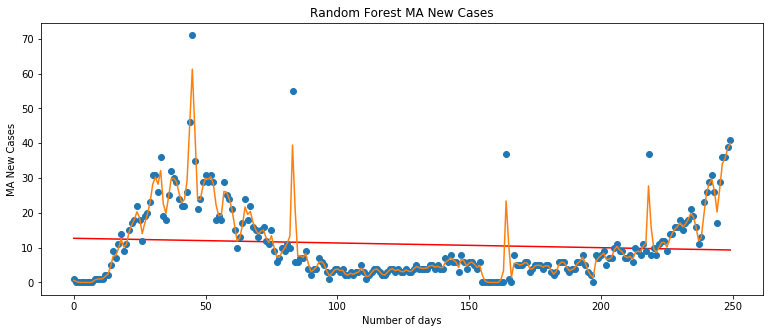

In [190]:
plt.figure(figsize=(8 * 1.618, 5))
Y = dailyTrendsCases["MACases"].values.reshape(-1, 1)
model = RandomForestRegressor()
model.fit(X, Y)

# Plot the data and the model prediction
y_fit = model.predict(X)

x = dailyTrendsCases['X']
y = dailyTrendsCases["MACases"] 
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r-")

plt.plot(X, Y, 'o')
plt.plot(X, y_fit);
plt.title('Random Forest MA New Cases')
plt.xlabel('Number of days')
plt.ylabel('MA New Cases')

In [205]:
print("RMSE MA: ",np.sqrt(mean_squared_error(Y, y_fit)))

RMSE MA:  3.9067874782229963


Text(0, 0.5, 'MA New Cases')

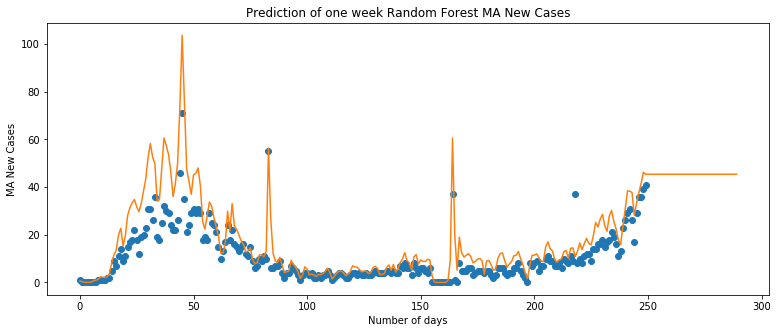

In [206]:
plt.figure(figsize=(8 * 1.618, 5))
Y = dailyTrendsCases["MACases"].values.reshape(-1, 1)

# Plot the data and the model prediction
y_fit = model.predict(Xx)

plt.plot(X, Y, 'o')
plt.plot(Xx, y_fit);
plt.title('Prediction of one week Random Forest MA New Cases')
plt.xlabel('Number of days')
plt.ylabel('MA New Cases')

C:\Users\sanam\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


Text(0, 0.5, 'Bristol New Cases')

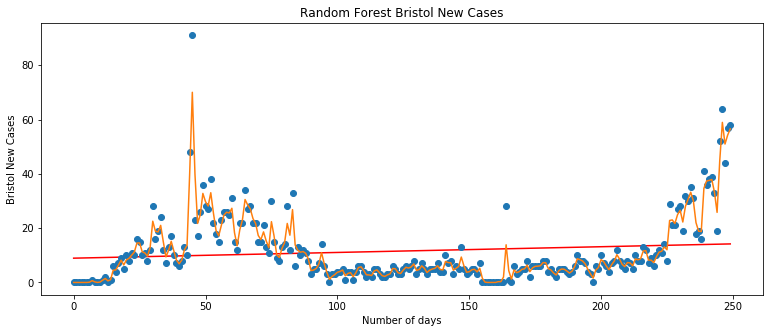

In [207]:
plt.figure(figsize=(8 * 1.618, 5))
Y = dailyTrendsCases["BristolCases"].values.reshape(-1, 1)
model = RandomForestRegressor()
model.fit(X, Y)

# Plot the data and the model prediction
y_fit = model.predict(X)

x = dailyTrendsCases['X']
y = dailyTrendsCases["BristolCases"] 
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r-")


plt.plot(X, Y, 'o')
plt.plot(X, y_fit);
plt.title('Random Forest Bristol New Cases')
plt.xlabel('Number of days')
plt.ylabel('Bristol New Cases')

In [208]:
print("RMSE Bristol: ",np.sqrt(mean_squared_error(Y, y_fit)))

RMSE Bristol:  2.7968342103170865


Text(0, 0.5, 'Bristol New Cases')

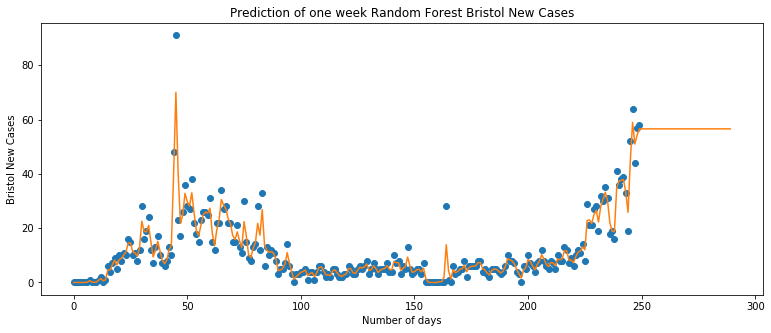

In [209]:
plt.figure(figsize=(8 * 1.618, 5))
Y = dailyTrendsCases["BristolCases"].values.reshape(-1, 1)

# Plot the data and the model prediction
y_fit = model.predict(Xx)

plt.plot(X, Y, 'o')
plt.plot(Xx, y_fit);
plt.title('Prediction of one week Random Forest Bristol New Cases')
plt.xlabel('Number of days')
plt.ylabel('Bristol New Cases')

C:\Users\sanam\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


Text(0, 0.5, 'Essex New Cases')

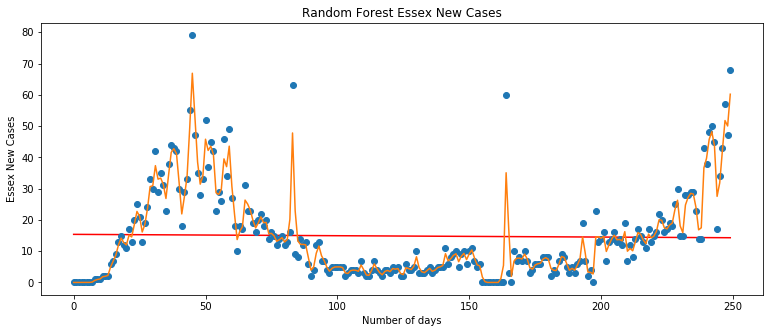

In [210]:
plt.figure(figsize=(8 * 1.618, 5))
Y = dailyTrendsCases["EssexCases"].values.reshape(-1, 1)
model = RandomForestRegressor()
model.fit(X, Y)

# Plot the data and the model prediction
y_fit = model.predict(X)

x = dailyTrendsCases['X']
y = dailyTrendsCases["EssexCases"] 
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r-")

plt.plot(X, Y, 'o')
plt.plot(X, y_fit);
plt.title('Random Forest Essex New Cases')
plt.xlabel('Number of days')
plt.ylabel('Essex New Cases')

In [211]:
print("RMSE Essex: ",np.sqrt(mean_squared_error(Y, y_fit)))

RMSE Essex:  3.195215923846149


Text(0, 0.5, 'Essex New Cases')

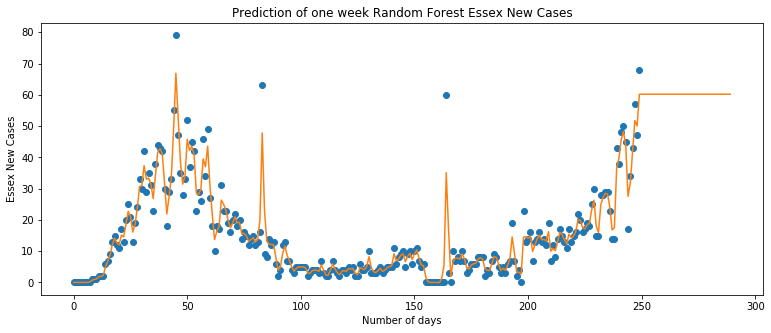

In [212]:
plt.figure(figsize=(8 * 1.618, 5))
Y = dailyTrendsCases["EssexCases"].values.reshape(-1, 1)

# Plot the data and the model prediction
y_fit = model.predict(Xx)

plt.plot(X, Y, 'o')
plt.plot(Xx, y_fit);
plt.title('Prediction of one week Random Forest Essex New Cases')
plt.xlabel('Number of days')
plt.ylabel('Essex New Cases')

C:\Users\sanam\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


Text(0, 0.5, 'Middlesex New Cases')

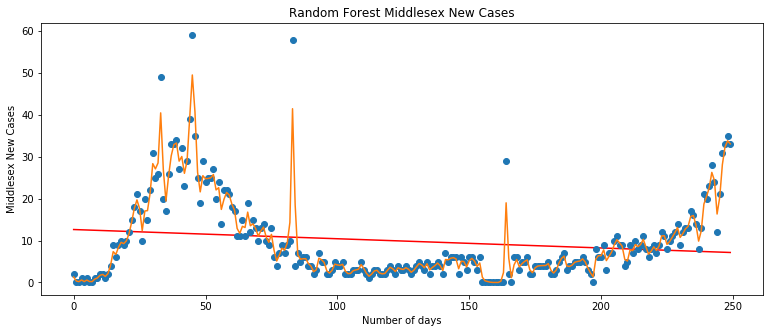

In [213]:
plt.figure(figsize=(8 * 1.618, 5))
Y = dailyTrendsCases["MiddlesexCases"].values.reshape(-1, 1)
model = RandomForestRegressor()
model.fit(X, Y)

# Plot the data and the model prediction
y_fit = model.predict(X)

x = dailyTrendsCases['X']
y = dailyTrendsCases["MiddlesexCases"] 
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r-")

plt.plot(X, Y, 'o')
plt.plot(X, y_fit);
plt.title('Random Forest Middlesex New Cases')
plt.xlabel('Number of days')
plt.ylabel('Middlesex New Cases')

In [214]:
print("RMSE Middlesex: ",np.sqrt(mean_squared_error(Y, y_fit)))

RMSE Middlesex:  2.1222569118747145


Text(0, 0.5, 'Middlesex New Cases')

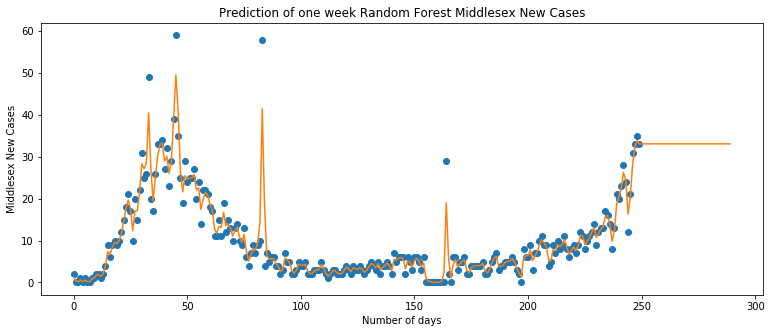

In [215]:
plt.figure(figsize=(8 * 1.618, 5))
Y = dailyTrendsCases["MiddlesexCases"].values.reshape(-1, 1)

# Plot the data and the model prediction
y_fit = model.predict(Xx)

plt.plot(X, Y, 'o')
plt.plot(Xx, y_fit);
plt.title('Prediction of one week Random Forest Middlesex New Cases')
plt.xlabel('Number of days')
plt.ylabel('Middlesex New Cases')

C:\Users\sanam\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


Text(0, 0.5, 'Plymouth New Cases')

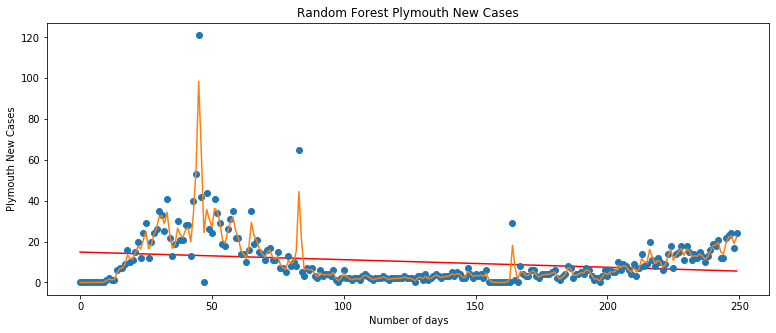

In [216]:
plt.figure(figsize=(8 * 1.618, 5))
Y = dailyTrendsCases["PlymouthCases"].values.reshape(-1, 1)
model = RandomForestRegressor()
model.fit(X, Y)

# Plot the data and the model prediction
y_fit = model.predict(X)

x = dailyTrendsCases['X']
y = dailyTrendsCases["PlymouthCases"] 
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r-")

plt.plot(X, Y, 'o')
plt.plot(X, y_fit);
plt.title('Random Forest Plymouth New Cases')
plt.xlabel('Number of days')
plt.ylabel('Plymouth New Cases')

In [217]:
print("RMSE Plymouth: ",np.sqrt(mean_squared_error(Y, y_fit)))

RMSE Plymouth:  3.548371908354591


Text(0, 0.5, 'Plymouth New Cases')

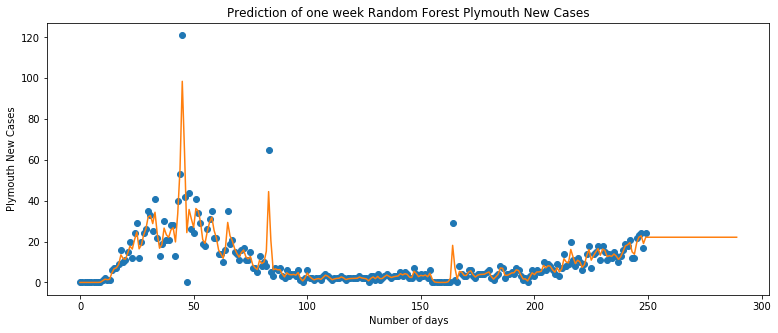

In [218]:
plt.figure(figsize=(8 * 1.618, 5))
Y = dailyTrendsCases["PlymouthCases"].values.reshape(-1, 1)

# Plot the data and the model prediction
y_fit = model.predict(Xx)

plt.plot(X, Y, 'o')
plt.plot(Xx, y_fit);
plt.title('Prediction of one week Random Forest Plymouth New Cases')
plt.xlabel('Number of days')
plt.ylabel('Plymouth New Cases')

C:\Users\sanam\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


Text(0, 0.5, 'Suffolk New Cases')

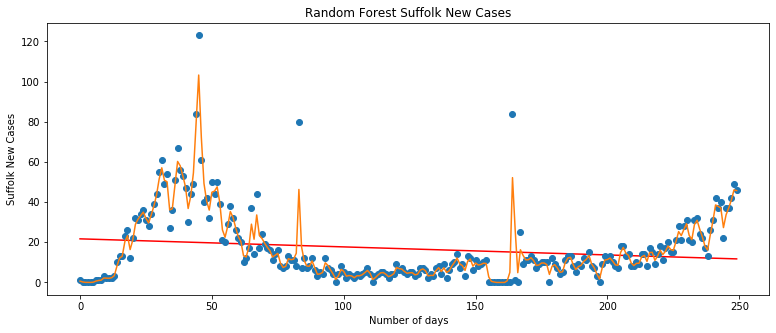

In [219]:
plt.figure(figsize=(8 * 1.618, 5))
Y = dailyTrendsCases["SuffolkCases"].values.reshape(-1, 1)
model = RandomForestRegressor()
model.fit(X, Y)

# Plot the data and the model prediction
y_fit = model.predict(X)

x = dailyTrendsCases['X']
y = dailyTrendsCases["SuffolkCases"] 
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r-")

plt.plot(X, Y, 'o')
plt.plot(X, y_fit);
plt.title('Random Forest Suffolk New Cases')
plt.xlabel('Number of days')
plt.ylabel('Suffolk New Cases')

In [220]:
print("RMSE Suffolk: ",np.sqrt(mean_squared_error(Y, y_fit)))

RMSE Suffolk:  4.376040264897022


Text(0, 0.5, 'Suffolk New Cases')

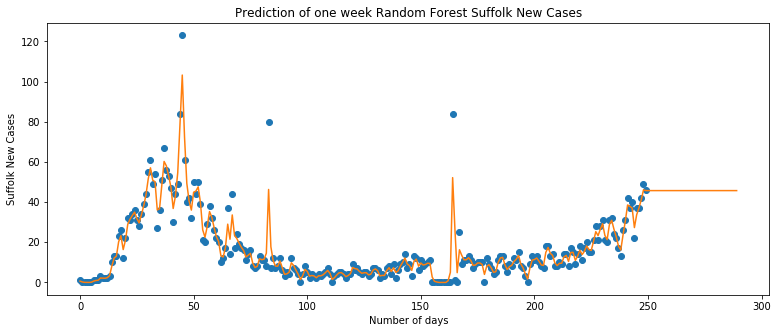

In [221]:
plt.figure(figsize=(8 * 1.618, 5))
Y = dailyTrendsCases["SuffolkCases"].values.reshape(-1, 1)

# Plot the data and the model prediction
y_fit1 = model.predict(Xx)

plt.plot(X, Y, 'o')
plt.plot(Xx, y_fit1);
plt.title('Prediction of one week Random Forest Suffolk New Cases')
plt.xlabel('Number of days')
plt.ylabel('Suffolk New Cases')

## Decision Tree

Text(0, 0.5, 'MA New Cases')

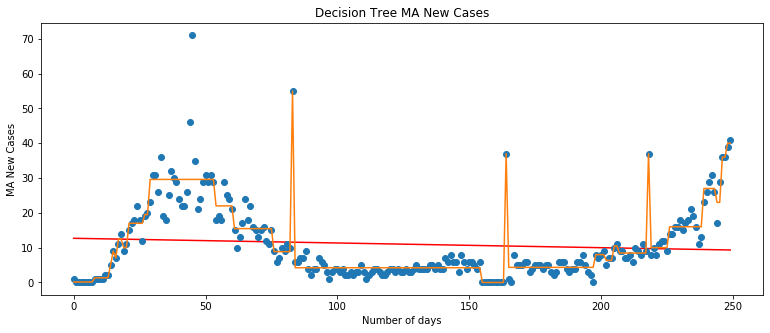

In [222]:
plt.figure(figsize=(8 * 1.618, 5))
Y = dailyTrendsCases["MACases"].values.reshape(-1, 1)
DT = DecisionTreeRegressor(max_depth = 5)
DT.fit(X, Y)

# Plot the data and the model prediction
y_fit = DT.predict(X)

x = dailyTrendsCases['X']
y = dailyTrendsCases["MACases"] 
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r-")

plt.plot(X, Y, 'o')
plt.plot(X, y_fit);
plt.title('Decision Tree MA New Cases')
plt.xlabel('Number of days')
plt.ylabel('MA New Cases')

In [223]:
print("RMSE MA: ",np.sqrt(mean_squared_error(Y, y_fit)))

RMSE MA:  3.797588944816574


Text(0, 0.5, 'MA New Cases')

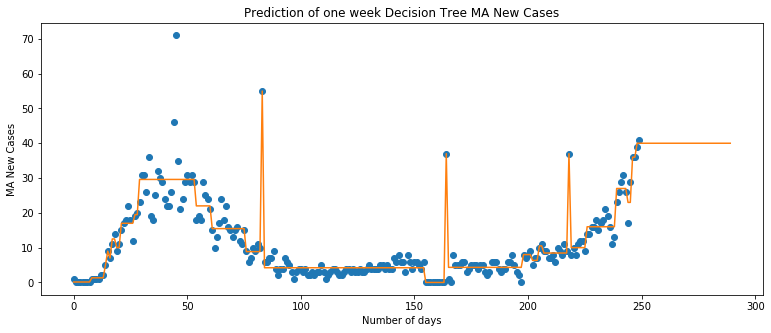

In [224]:
plt.figure(figsize=(8 * 1.618, 5))
Y = dailyTrendsCases["MACases"].values.reshape(-1, 1)

# Plot the data and the model prediction
y_fit1 = DT.predict(Xx)

plt.plot(X, Y, 'o')
plt.plot(Xx, y_fit1);
plt.title('Prediction of one week Decision Tree MA New Cases')
plt.xlabel('Number of days')
plt.ylabel('MA New Cases')

Text(0, 0.5, 'Bristol New Cases')

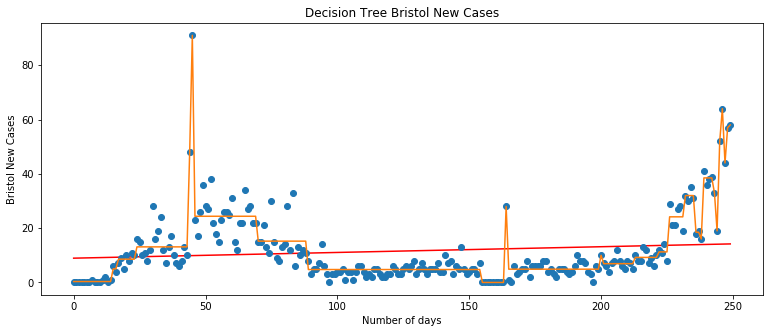

In [225]:
plt.figure(figsize=(8 * 1.618, 5))
Y = dailyTrendsCases["BristolCases"].values.reshape(-1, 1)
DT = DecisionTreeRegressor(max_depth = 5)
DT.fit(X, Y)

# Plot the data and the model prediction
y_fit = DT.predict(X)

x = dailyTrendsCases['X']
y = dailyTrendsCases["BristolCases"] 
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r-")

plt.plot(X, Y, 'o')
plt.plot(X, y_fit);
plt.title('Decision Tree Bristol New Cases')
plt.xlabel('Number of days')
plt.ylabel('Bristol New Cases')

In [226]:
print("RMSE Bristol: ",np.sqrt(mean_squared_error(Y, y_fit)))

RMSE Bristol:  3.69910807552528


Text(0, 0.5, 'Bristol New Cases')

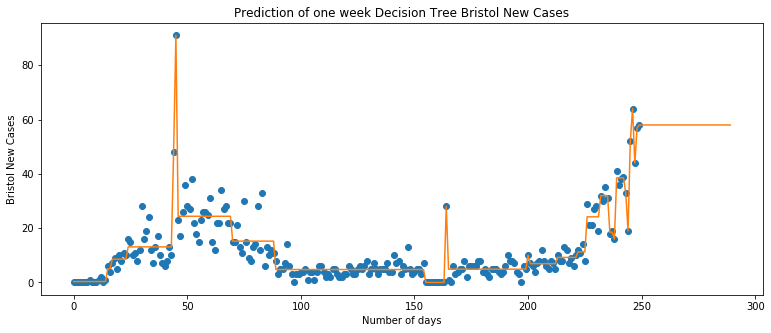

In [227]:
plt.figure(figsize=(8 * 1.618, 5))
Y = dailyTrendsCases["BristolCases"].values.reshape(-1, 1)

# Plot the data and the model prediction
y_fit1 = DT.predict(Xx)

plt.plot(X, Y, 'o')
plt.plot(Xx, y_fit1);
plt.title('Prediction of one week Decision Tree Bristol New Cases')
plt.xlabel('Number of days')
plt.ylabel('Bristol New Cases')

Text(0, 0.5, 'Essex New Cases')

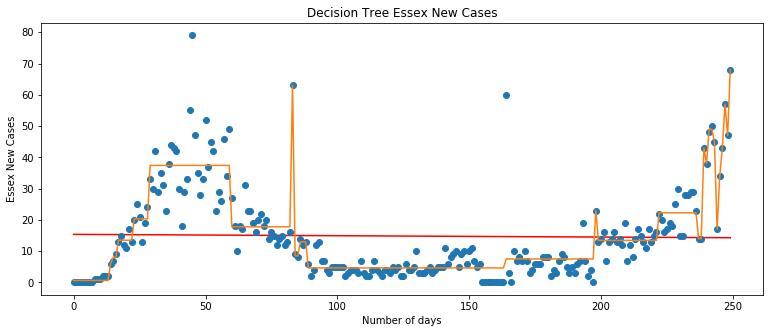

In [228]:
plt.figure(figsize=(8 * 1.618, 5))
Y = dailyTrendsCases["EssexCases"].values.reshape(-1, 1)
DT = DecisionTreeRegressor(max_depth = 5)
DT.fit(X, Y)

# Plot the data and the model prediction
y_fit = DT.predict(X)

x = dailyTrendsCases['X']
y = dailyTrendsCases["EssexCases"] 
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r-")


plt.plot(X, Y, 'o')
plt.plot(X, y_fit);
plt.title('Decision Tree Essex New Cases')
plt.xlabel('Number of days')
plt.ylabel('Essex New Cases')

In [229]:
print("RMSE Essex: ",np.sqrt(mean_squared_error(Y, y_fit)))

RMSE Essex:  6.145038504962854


Text(0, 0.5, 'Essex New Cases')

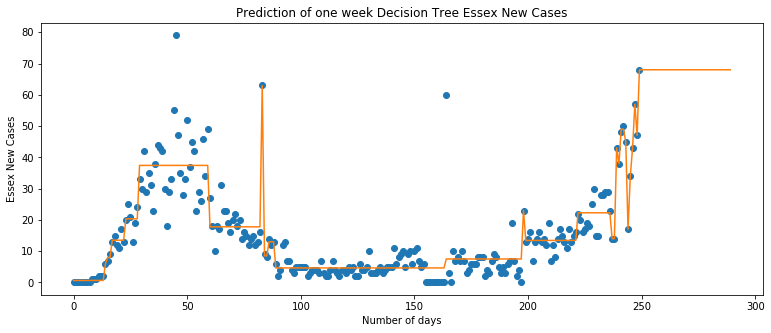

In [230]:
plt.figure(figsize=(8 * 1.618, 5))
Y = dailyTrendsCases["EssexCases"].values.reshape(-1, 1)

# Plot the data and the model prediction
y_fit1 = DT.predict(Xx)

plt.plot(X, Y, 'o')
plt.plot(Xx, y_fit1);
plt.title('Prediction of one week Decision Tree Essex New Cases')
plt.xlabel('Number of days')
plt.ylabel('Essex New Cases')

Text(0, 0.5, 'Middlesex New Cases')

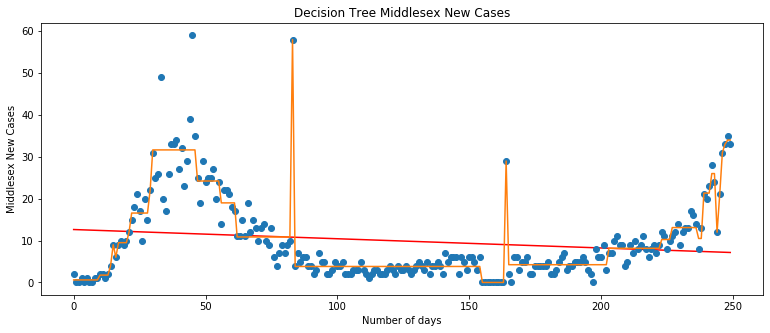

In [231]:
plt.figure(figsize=(8 * 1.618, 5))
Y = dailyTrendsCases["MiddlesexCases"].values.reshape(-1, 1)
DT = DecisionTreeRegressor(max_depth = 5)
DT.fit(X, Y)

# Plot the data and the model prediction
y_fit = DT.predict(X)

x = dailyTrendsCases['X']
y = dailyTrendsCases["MiddlesexCases"] 
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r-")

plt.plot(X, Y, 'o')
plt.plot(X, y_fit);
plt.title('Decision Tree Middlesex New Cases')
plt.xlabel('Number of days')
plt.ylabel('Middlesex New Cases')

In [232]:
print("RMSE Middlesex: ",np.sqrt(mean_squared_error(Y, y_fit)))

RMSE Middlesex:  3.224114407902799


Text(0, 0.5, 'Middlesex New Cases')

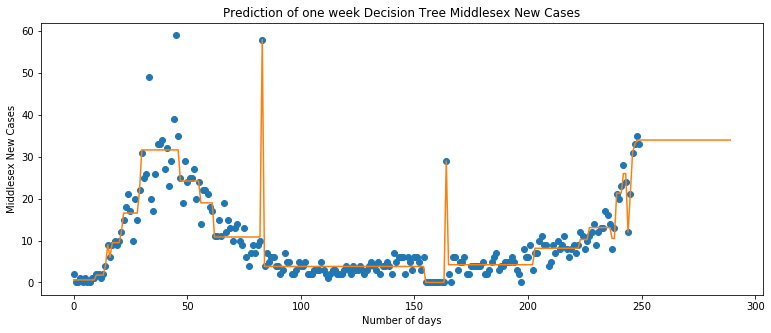

In [233]:
plt.figure(figsize=(8 * 1.618, 5))
Y = dailyTrendsCases["MiddlesexCases"].values.reshape(-1, 1)

# Plot the data and the model prediction
y_fit1 = DT.predict(Xx)

plt.plot(X, Y, 'o')
plt.plot(Xx, y_fit1);
plt.title('Prediction of one week Decision Tree Middlesex New Cases')
plt.xlabel('Number of days')
plt.ylabel('Middlesex New Cases')

Text(0, 0.5, 'Plymouth New Cases')

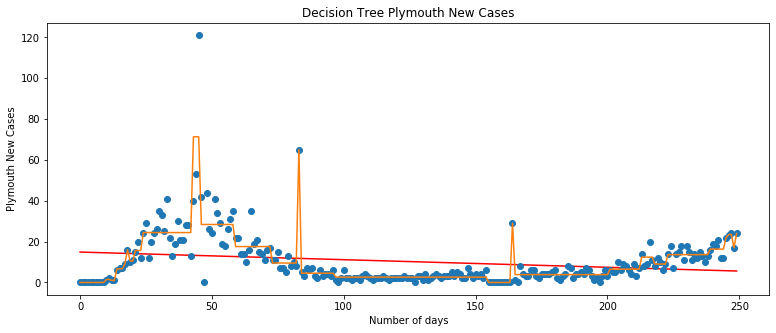

In [234]:
plt.figure(figsize=(8 * 1.618, 5))
Y = dailyTrendsCases["PlymouthCases"].values.reshape(-1, 1)
DT = DecisionTreeRegressor(max_depth = 5)
DT.fit(X, Y)

# Plot the data and the model prediction
y_fit = DT.predict(X)

x = dailyTrendsCases['X']
y = dailyTrendsCases["PlymouthCases"] 
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r-")

plt.plot(X, Y, 'o')
plt.plot(X, y_fit);
plt.title('Decision Tree Plymouth New Cases')
plt.xlabel('Number of days')
plt.ylabel('Plymouth New Cases')

In [235]:
print("RMSE Plymouth: ",np.sqrt(mean_squared_error(Y, y_fit)))

RMSE Plymouth:  5.592327059949835


Text(0, 0.5, 'Plymouth New Cases')

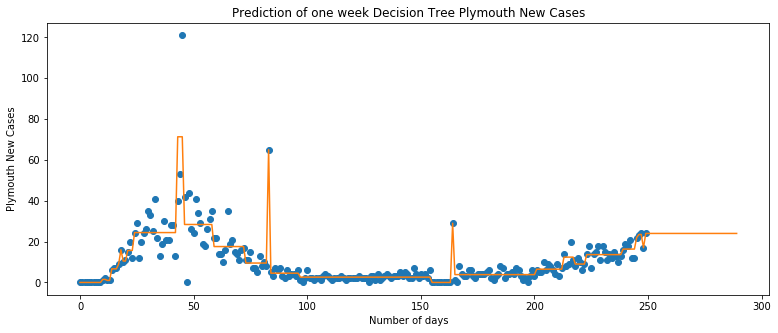

In [236]:
plt.figure(figsize=(8 * 1.618, 5))
Y = dailyTrendsCases["PlymouthCases"].values.reshape(-1, 1)

# Plot the data and the model prediction
y_fit1 = DT.predict(Xx)

plt.plot(X, Y, 'o')
plt.plot(Xx, y_fit1);
plt.title('Prediction of one week Decision Tree Plymouth New Cases')
plt.xlabel('Number of days')
plt.ylabel('Plymouth New Cases')

Text(0, 0.5, 'Suffolk New Cases')

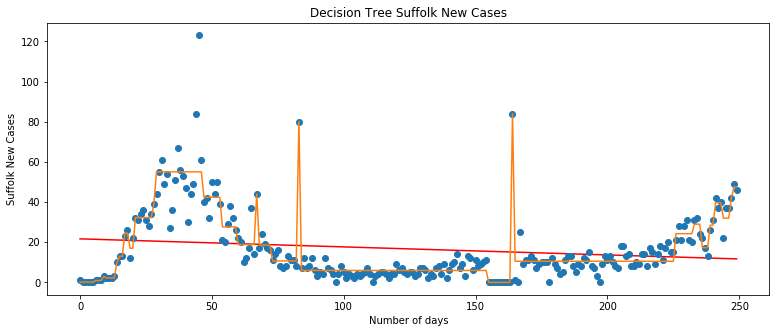

In [237]:
plt.figure(figsize=(8 * 1.618, 5))
Y = dailyTrendsCases["SuffolkCases"].values.reshape(-1, 1)
DT = DecisionTreeRegressor(max_depth = 5)
DT.fit(X, Y)

# Plot the data and the model prediction
y_fit = DT.predict(X)

x = dailyTrendsCases['X']
y = dailyTrendsCases["SuffolkCases"] 
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r-")

plt.plot(X, Y, 'o')
plt.plot(X, y_fit);
plt.title('Decision Tree Suffolk New Cases')
plt.xlabel('Number of days')
plt.ylabel('Suffolk New Cases')

In [238]:
print("RMSE Suffolk : ",np.sqrt(mean_squared_error(Y, y_fit)))

RMSE Suffolk :  6.79132217431288


Text(0, 0.5, 'Suffolk New Cases')

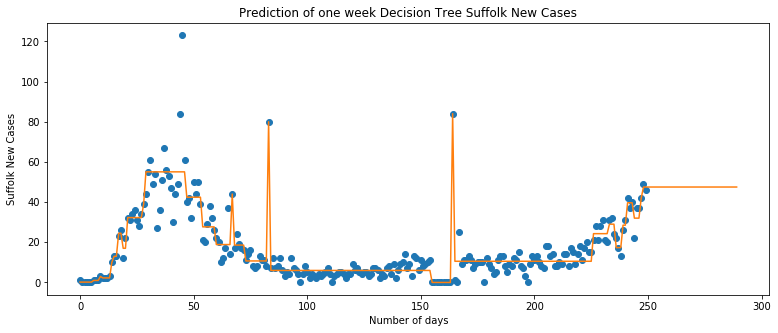

In [239]:
plt.figure(figsize=(8 * 1.618, 5))
Y = dailyTrendsCases["SuffolkCases"].values.reshape(-1, 1)

# Plot the data and the model prediction
y_fit1 = DT.predict(Xx)

plt.plot(X, Y, 'o')
plt.plot(Xx, y_fit1);
plt.title('Prediction of one week Decision Tree Suffolk New Cases')
plt.xlabel('Number of days')
plt.ylabel('Suffolk New Cases')

## ARIMA

#### For ARIMA we need to convert the index into type date

In [245]:
from datetime import datetime
#Make a column from index which contains the dates
dailyCases['date'] = dailyCases.index

# #remove unwanted characters
dailyCases["date"] = dailyCases["date"].str.replace('_','')
dailyCases["date"] = dailyCases["date"].str.replace('x','20')

#Convert each value in the column to the date object
l = []
for i in range (len(dailyCases["date"])):
    l.append(datetime.strptime(dailyCases["date"][i],'%m/%d/%Y').date())
    
dailyCases["date"] = l
dailyCases.set_index('date', inplace = True)



In [272]:
dailyCases

,MACases,BristolCases,EssexCases,MiddlesexCases,PlymouthCases,SuffolkCases,date
date,,,,,,,
2020-01-22,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-22
2020-01-23,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-23
2020-01-24,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-24
2020-01-25,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-25
2020-01-26,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-26
...,...,...,...,...,...,...,...
2020-11-10,2029.0,292.0,268.0,339.0,114.0,301.0,2020-11-10
2020-11-11,2495.0,364.0,342.0,507.0,120.0,296.0,2020-11-11
2020-11-12,2484.0,246.0,447.0,528.0,124.0,337.0,2020-11-12


In [273]:
xax = [*range(50, 298, 1)]

### Orange line in the graphs shows the prediction and the blue one is the actual one

C:\Users\sanam\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\sanam\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\sanam\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Text(0, 0.5, 'MA New Cases')

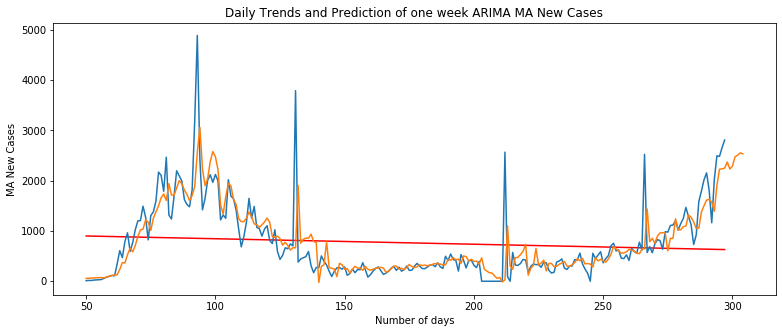

In [288]:
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA

df = dailyCases["MACases"].to_frame()
AR = AR(df)
AR_fit = AR.fit()
df["pred"] = AR_fit.predict(start =50  , end =298)

#7 days
AR = ARIMA(dailyCases["MACases"], order=(7,1,1))
AR_fit = AR.fit(disp=0)
output = AR_fit.forecast()
#predict next 7 days
prediction = AR_fit.forecast(steps = 7)[0]

df = df.append(pd.DataFrame({'pred': prediction}), ignore_index=True)

plt.figure(figsize=(8 * 1.618, 5))

x = xax
y = dailyCases["MACases"][50:] 
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r-")


plt.plot(df.index[50:], df["MACases"][50:])
plt.plot(df.index[50:], df["pred"][50:]);
plt.title('Daily Trends and Prediction of one week ARIMA MA New Cases')
plt.xlabel('Number of days')
plt.ylabel('MA New Cases')



In [275]:
# plt.plot(df.index[50:], df["MACases"][50:], 'o')
# plt.plot(df.index[50:], df["pred"][50:]);
# plt.title('Daily Trends and Prediction of one week ARIMA MA New Cases')
# plt.xlabel('Number of days')
# plt.ylabel('MA New Cases')

C:\Users\sanam\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\sanam\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\sanam\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Text(0, 0.5, 'Bristol New Cases')

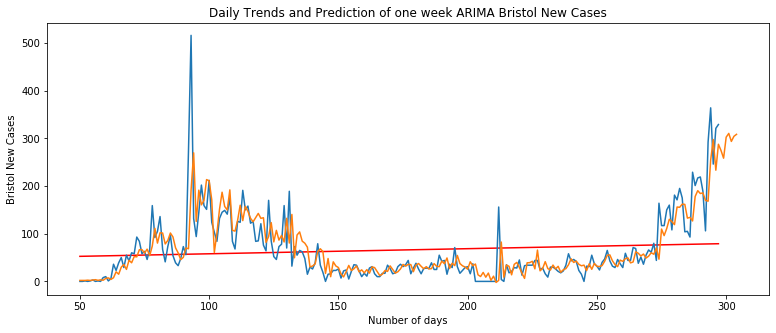

In [289]:
from statsmodels.tsa.ar_model import AR
df = dailyCases["BristolCases"].to_frame()
AR = AR(df)
AR_fit = AR.fit()
df["pred"] = AR_fit.predict(start =50  , end =298)

#7 days
AR = ARIMA(dailyCases["BristolCases"], order=(7,1,1))
AR_fit = AR.fit(disp=0)
output = AR_fit.forecast()
#predict next 7 days
prediction = AR_fit.forecast(steps = 7)[0]

df = df.append(pd.DataFrame({'pred': prediction}), ignore_index=True)

plt.figure(figsize=(8 * 1.618, 5))

x = xax
y = dailyCases["BristolCases"][50:] 
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r-")

plt.plot(df.index[50:], df["BristolCases"][50:])
plt.plot(df.index[50:], df["pred"][50:]);
plt.title('Daily Trends and Prediction of one week ARIMA Bristol New Cases')
plt.xlabel('Number of days')
plt.ylabel('Bristol New Cases')

C:\Users\sanam\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\sanam\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\sanam\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Text(0, 0.5, 'Essex New Cases')

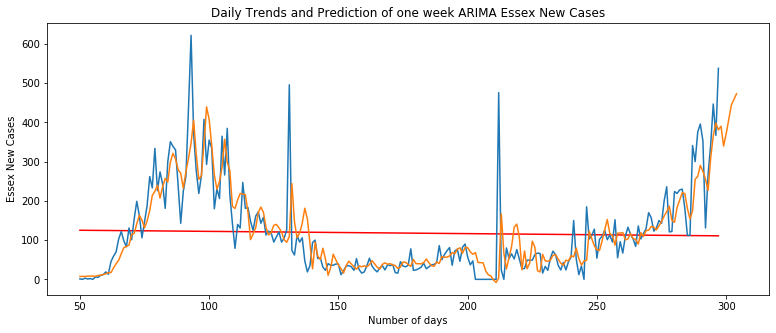

In [290]:
from statsmodels.tsa.ar_model import AR
df = dailyCases["EssexCases"].to_frame()
AR = AR(df)
AR_fit = AR.fit()
df["pred"] = AR_fit.predict(start =50  , end =298)

#7 days
AR = ARIMA(dailyCases["EssexCases"], order=(7,1,1))
AR_fit = AR.fit(disp=0)
output = AR_fit.forecast()
#predict next 7 days
prediction = AR_fit.forecast(steps = 7)[0]

df = df.append(pd.DataFrame({'pred': prediction}), ignore_index=True)

plt.figure(figsize=(8 * 1.618, 5))

x = xax
y = dailyCases["EssexCases"][50:] 
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r-")

plt.plot(df.index[50:], df["EssexCases"][50:])
plt.plot(df.index[50:], df["pred"][50:]);
plt.title('Daily Trends and Prediction of one week ARIMA Essex New Cases')
plt.xlabel('Number of days')
plt.ylabel('Essex New Cases')

C:\Users\sanam\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\sanam\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\sanam\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Text(0, 0.5, 'Middlesex New Cases')

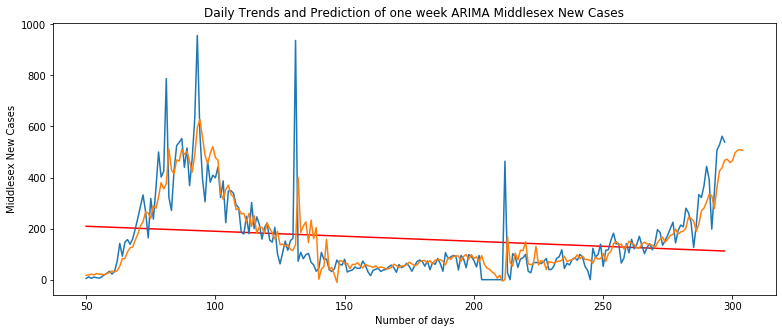

In [291]:
from statsmodels.tsa.ar_model import AR
df = dailyCases["MiddlesexCases"].to_frame()
AR = AR(df)
AR_fit = AR.fit()
df["pred"] = AR_fit.predict(start =50  , end =298)

#7 days
AR = ARIMA(dailyCases["MiddlesexCases"], order=(7,1,1))
AR_fit = AR.fit(disp=0)
output = AR_fit.forecast()
#predict next 7 days
prediction = AR_fit.forecast(steps = 7)[0]

df = df.append(pd.DataFrame({'pred': prediction}), ignore_index=True)

plt.figure(figsize=(8 * 1.618, 5))

x = xax
y = dailyCases["MiddlesexCases"][50:] 
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r-")

plt.plot(df.index[50:], df["MiddlesexCases"][50:])
plt.plot(df.index[50:], df["pred"][50:]);
plt.title('Daily Trends and Prediction of one week ARIMA Middlesex New Cases')
plt.xlabel('Number of days')
plt.ylabel('Middlesex New Cases')

C:\Users\sanam\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\sanam\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\sanam\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Text(0, 0.5, 'Plymouth New Cases')

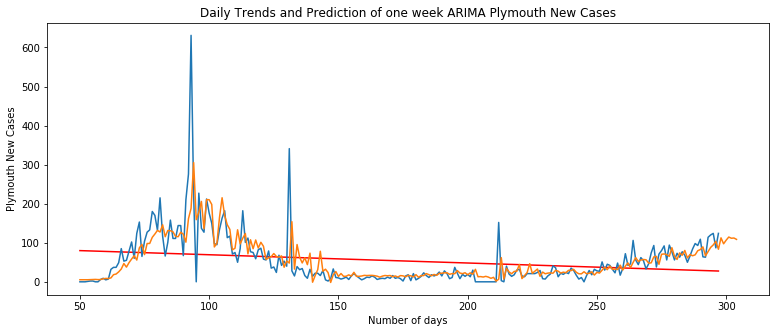

In [292]:
from statsmodels.tsa.ar_model import AR
df = dailyCases["PlymouthCases"].to_frame()
AR = AR(df)
AR_fit = AR.fit()
df["pred"] = AR_fit.predict(start =50  , end =298)

#7 days
AR = ARIMA(dailyCases["PlymouthCases"], order=(7,1,1))
AR_fit = AR.fit(disp=0)
output = AR_fit.forecast()
#predict next 7 days
prediction = AR_fit.forecast(steps = 7)[0]

df = df.append(pd.DataFrame({'pred': prediction}), ignore_index=True)

plt.figure(figsize=(8 * 1.618, 5))

x = xax
y = dailyCases["PlymouthCases"][50:] 
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r-")

plt.plot(df.index[50:], df["PlymouthCases"][50:])
plt.plot(df.index[50:], df["pred"][50:]);
plt.title('Daily Trends and Prediction of one week ARIMA Plymouth New Cases')
plt.xlabel('Number of days')
plt.ylabel('Plymouth New Cases')

C:\Users\sanam\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\sanam\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\sanam\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Text(0, 0.5, 'Suffolk New Cases')

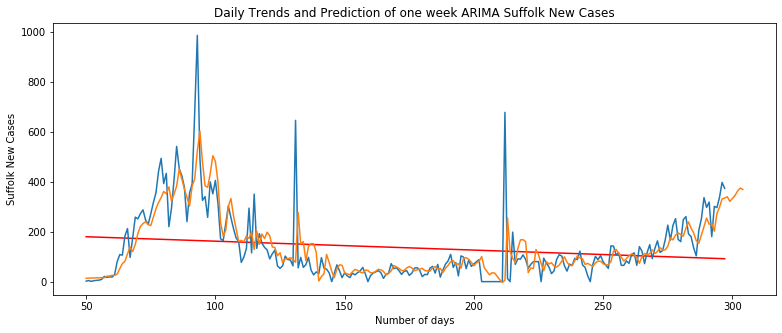

In [293]:
from statsmodels.tsa.ar_model import AR
df = dailyCases["SuffolkCases"].to_frame()
AR = AR(df)
AR_fit = AR.fit()
df["pred"] = AR_fit.predict(start =50  , end =298)

#7 days
AR = ARIMA(dailyCases["SuffolkCases"], order=(7,1,1))
AR_fit = AR.fit(disp=0)
output = AR_fit.forecast()
#predict next 7 days
prediction = AR_fit.forecast(steps = 7)[0]

df = df.append(pd.DataFrame({'pred': prediction}), ignore_index=True)

plt.figure(figsize=(8 * 1.618, 5))

x = xax
y = dailyCases["SuffolkCases"][50:] 
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r-")

plt.plot(df.index[50:], df["SuffolkCases"][50:])
plt.plot(df.index[50:], df["pred"][50:]);
plt.title('Daily Trends and Prediction of one week ARIMA Suffolk New Cases')
plt.xlabel('Number of days')
plt.ylabel('Suffolk New Cases')

## Use 5 different variables from the enrichment data to predict the spread rate (cases and deaths) of COVID-19 in a county. Compare Random Forest and Decision Trees (RMSE error).

In [305]:
MACounties
MACounties = MACounties[MACounties["County Name"] != "Dukes County"]
MACounties = MACounties[MACounties["County Name"] != "Franklin County"]
MACounties = MACounties[MACounties["County Name"] != "Nantucket County"]

In [306]:
MACounties

,countyFIPS,County Name,State,population,stateFIPS,1/22/20_x,1/23/20_x,1/24/20_x,1/25/20_x,1/26/20_x,...,11/5/20_y,11/6/20_y,11/7/20_y,11/8/20_y,11/9/20_y,11/10/20_y,11/11/20_y,11/12/20_y,11/13/20_y,11/14/20_y
1240,25001,Barnstable County,MA,212990,25,0,0,0,0,0,...,186,186,186,186,186,186,186,186,186,187
1241,25003,Berkshire County,MA,124944,25,0,0,0,0,0,...,52,52,52,52,52,52,52,52,52,52
1242,25005,Bristol County,MA,565217,25,0,0,0,0,0,...,771,771,773,774,777,780,784,785,789,792
1244,25009,Essex County,MA,789034,25,0,0,0,0,0,...,1362,1364,1366,1369,1372,1374,1382,1384,1387,1390
1246,25013,Hampden County,MA,466372,25,0,0,0,0,0,...,830,834,836,838,839,842,842,844,845,849
1247,25015,Hampshire County,MA,160830,25,0,0,0,0,0,...,157,158,158,158,158,158,158,158,159,160
1248,25017,Middlesex County,MA,1611699,25,0,0,0,0,0,...,2305,2310,2314,2319,2322,2325,2333,2341,2347,2351
1250,25021,Norfolk County,MA,706775,25,0,0,0,0,0,...,1118,1121,1121,1127,1127,1130,1136,1137,1139,1147
1251,25023,Plymouth County,MA,521202,25,0,0,0,0,0,...,848,848,850,851,851,855,862,862,863,865
1252,25025,Suffolk County,MA,803907,25,0,0,0,0,0,...,1189,1191,1193,1198,1201,1201,1201,1203,1204,1205


In [307]:
MACountiesCases = MACounties.filter(regex = "x")
MACountiesDeaths = MACounties.filter(regex = "y")

In [308]:
CountiesTotalCases = MACountiesCases["9/9/20_x"].to_frame()
CountiesTotalDeaths = MACountiesDeaths["9/9/20_y"].to_frame()

In [309]:
population = [212990, 124944, 565217, 789034, 466372, 160830, 1611699, 706775, 521202, 803907, 830622]
normCases = [1778, 1146, 3559, 4886, 3483, 1611, 3496, 3170, 3757, 5974, 3468]
normDeaths = [159, 74, 236, 318, 325, 175, 259, 290, 287, 276, 256]

CountiesTotalCases["9/9/20_x"] = normCases
CountiesTotalDeaths["9/9/20_y"] = normDeaths

In [310]:
CountiesTotalCases

,9/9/20_x
1240,1778
1241,1146
1242,3559
1244,4886
1246,3483
1247,1611
1248,3496
1250,3170
1251,3757
1252,5974


In [323]:
#read enrichment dataset
demographic = pd.read_csv("../../../data/Demographic.csv")
# demographic = pd.read_csv("../../../src/Stage_I/Sanam/Demographic.csv")
# hospital = pd.read_csv("../../../data/Hospital_Beds.csv", index_col=0)
demographic.columns = demographic.iloc[0]
demographic.drop(demographic.index[0],inplace = True)
demographic.head()

,id,Geographic Area Name,Percent Margin of Error!!SEX AND AGE!!Total population!!65 years and over!!Female,Estimate!!SEX AND AGE!!Total population!!65 years and over!!Sex ratio (males per 100 females),Margin of Error!!SEX AND AGE!!Total population!!65 years and over!!Sex ratio (males per 100 females),Percent Estimate!!SEX AND AGE!!Total population!!65 years and over!!Sex ratio (males per 100 females),Percent Margin of Error!!SEX AND AGE!!Total population!!65 years and over!!Sex ratio (males per 100 females),Estimate!!RACE!!Total population,Margin of Error!!RACE!!Total population,Percent Estimate!!RACE!!Total population,...,Margin of Error!!SEX AND AGE!!Total population!!65 years and over,Percent Estimate!!SEX AND AGE!!Total population!!65 years and over,Percent Margin of Error!!SEX AND AGE!!Total population!!65 years and over,Estimate!!SEX AND AGE!!Total population!!65 years and over!!Male,Margin of Error!!SEX AND AGE!!Total population!!65 years and over!!Male,Percent Estimate!!SEX AND AGE!!Total population!!65 years and over!!Male,Percent Margin of Error!!SEX AND AGE!!Total population!!65 years and over!!Male,Estimate!!SEX AND AGE!!Total population!!65 years and over!!Female,Margin of Error!!SEX AND AGE!!Total population!!65 years and over!!Female,Percent Estimate!!SEX AND AGE!!Total population!!65 years and over!!Female
1,0500000US01001,"Autauga County, Alabama",0.4,76.5,1.2,(X),(X),55200,*****,55200,...,75,8050,(X),3488,30,43.3,0.4,4562,65,56.7
2,0500000US01003,"Baldwin County, Alabama",0.1,86.6,0.3,(X),(X),208107,*****,208107,...,69,40665,(X),18870,40,46.4,0.1,21795,56,53.6
3,0500000US01005,"Barbour County, Alabama",0.2,76.2,0.6,(X),(X),25782,*****,25782,...,29,4634,(X),2004,16,43.2,0.2,2630,19,56.8
4,0500000US01007,"Bibb County, Alabama",1.3,80.5,4.3,(X),(X),22527,*****,22527,...,161,3661,(X),1633,74,44.6,1.3,2028,114,55.4
5,0500000US01009,"Blount County, Alabama",0.5,79.7,1.7,(X),(X),57645,*****,57645,...,91,10233,(X),4540,77,44.4,0.5,5693,60,55.6


In [325]:
# Remove columns which shows margin of errors, percent estimate and percent margin of error 

# demographic = demographic[demographic.columns.drop(list(demographic.filter(regex='Margin')))]
# demographic = demographic[demographic.columns.drop(list(demographic.filter(regex='Percent')))]

In [326]:
# demographic.loc[demographic['State'] == "Alabama"]

In [328]:
#Select column "id" from Demographic_df, and choose a substring of each value in the column which contains county FIPS,
#and append it to a list   

# county_FIPS_list = []
# for i in range(len(demographic["id"])):
#     county_FIPS_list.append(demographic.loc[i,'id'][9:])
    
# #Add the list as a new column to the Demographic_df     
# demographic["countyFIPS"] = county_FIPS_list

# #Convert the type of countyFIPS from string to int
# demographic['countyFIPS'] = demographic['countyFIPS'].astype(int)

In [329]:
# Split geographical area name into county and state name

demographic[['County Name','State']] = demographic["Geographic Area Name"].str.split(",",expand=True)

In [330]:
demographic = demographic[demographic['Geographic Area Name'].str.contains('Massachusetts')]
demographic = demographic[demographic["Geographic Area Name"] != "Dukes County, Massachusetts"]
demographic = demographic[demographic["Geographic Area Name"] != "Franklin County, Massachusetts"]
demographic = demographic[demographic["Geographic Area Name"] != "Nantucket County, Massachusetts"]
# demographic = demographic.loc[demographic['Geographic Area Name'].isin(['Bristol County, Massachusetts', 'Essex County, Massachusetts','Middlesex County, Massachusetts',
#                                                                         'Plymouth County, Massachusetts','Suffolk County, Massachusetts'])]

In [336]:
cl = ["Geographic Area Name","Estimate!!SEX AND AGE!!Total population!!Sex ratio (males per 100 females)","Estimate!!SEX AND AGE!!Total population!!Median age (years)",
      "Estimate!!SEX AND AGE!!Total population!!65 years and over" ,"Estimate!!RACE!!Total population!!Two or more races!!White and Asian","Estimate!!HISPANIC OR LATINO AND RACE!!Total population!!Hispanic or Latino (of any race)"
     ,"Estimate!!SEX AND AGE!!Total population!!18 years and over!!Male","Estimate!!SEX AND AGE!!Total population!!18 years and over!!Female"]
demographic = demographic[cl]
# demographic.columns = ["Geographic Area Name","Sex ratio(males per 100 females)","Median age (years)","65 years and over",
#                        "Two or more races!!White and Asian","Hispanic or Latino (of any race)",
#                         "18 years and over!!Male","18 years and over!!Female"]
# demographic.columns =["Geographic Area Name","Sex ratio (males per 100 females)","Median age (years)","65 years and over",
#                      ""]
# demographic

In [717]:
DF = demographic.transpose()
DF.columns = DF.iloc[0]
DF.drop(DF.index[0],inplace = True)
DF

Geographic Area Name,"Barnstable County, Massachusetts","Berkshire County, Massachusetts","Bristol County, Massachusetts","Essex County, Massachusetts","Hampden County, Massachusetts","Hampshire County, Massachusetts","Middlesex County, Massachusetts","Norfolk County, Massachusetts","Plymouth County, Massachusetts","Suffolk County, Massachusetts","Worcester County, Massachusetts"
Sex ratio(males per 100 females),91.6,93.7,93.9,93.1,93.4,88,95.6,92.4,94.7,93.6,97.3
Median age (years),52.9,46.7,41,40.8,38.9,36.3,38.5,40.9,42.6,32.7,40.1
65 years and over,62229,28064,91150,127337,75229,25710,234069,113400,87718,91123,122402
Two or more races!!White and Asian,720,513,2017,3376,1820,1845,16685,6094,1999,5274,4979
Hispanic or Latino (of any race),6228,5839,43042,158974,115479,8882,125533,30363,19476,179702,91732
18 years and over!!Male,85315,50295,211290,289878,173743,62919,615747,259379,191399,314861,314803
18 years and over!!Female,95262,54900,231018,322049,192470,73905,658231,289964,208213,342736,330743


In [718]:
l1 = []
l1 = ((DF["Barnstable County, Massachusetts"][2:]/212990)*200000)
for i in range(4):
    DF["Barnstable County, Massachusetts"][i+2] = l1[i]
    
l2 = []
l2 = ((DF["Berkshire County, Massachusetts"][2:]/124944)*200000)
for i in range(4):
    DF["Berkshire County, Massachusetts"][i+2] = l2[i]

l3 = []
l3 = ((DF["Bristol County, Massachusetts"][2:]/565217)*200000)
for i in range(4):
    DF["Bristol County, Massachusetts"][i+2] = l3[i]
        
l4 = []
l4 = ((DF["Essex County, Massachusetts"][2:]/789034)*200000)
for i in range(4):
    DF["Essex County, Massachusetts"][i+2] = l4[i]
    
l5 = []
l5 = ((DF["Hampden County, Massachusetts"][2:]/466372)*200000)
for i in range(4):
    DF["Hampden County, Massachusetts"][i+2] = l5[i]
    
l6 = []
l6 = ((DF["Hampshire County, Massachusetts"][2:]/160830)*200000)
for i in range(4):
    DF["Hampshire County, Massachusetts"][i+2] = l6[i]
    
l7 = []
l7 = ((DF["Middlesex County, Massachusetts"][2:]/1611699)*200000)
for i in range(4):
    DF["Middlesex County, Massachusetts"][i+2] = l7[i]
    
l8 = []
l8 = ((DF["Norfolk County, Massachusetts"][2:]/706775)*200000)
for i in range(4):
    DF["Norfolk County, Massachusetts"][i+2] = l8[i]
    
l9 = []
l9 = ((DF["Plymouth County, Massachusetts"][2:]/521202)*200000)
for i in range(4):
    DF["Plymouth County, Massachusetts"][i+2] = l9[i]
    
l10 = []
l10 = ((DF["Suffolk County, Massachusetts"][2:]/803907)*200000)
for i in range(4):
    DF["Suffolk County, Massachusetts"][i+2] = l10[i]
    
l11 = []
l11 = ((DF["Worcester County, Massachusetts"][2:]/830622)*200000)
for i in range(4):
    DF["Worcester County, Massachusetts"][i+2] = l11[i]    

In [720]:
TDF = DF.transpose()
TDF

,Sex ratio(males per 100 females),Median age (years),65 years and over,Two or more races!!White and Asian,Hispanic or Latino (of any race),18 years and over!!Male,18 years and over!!Female
Geographic Area Name,,,,,,,
"Barnstable County, Massachusetts",91.6,52.9,58433.7,676.088,5848.16,80111.7,95262
"Berkshire County, Massachusetts",93.7,46.7,44922.5,821.168,9346.59,80508.1,54900
"Bristol County, Massachusetts",93.9,41,32253.1,713.708,15230.3,74764.2,231018
"Essex County, Massachusetts",93.1,40.8,32276.7,855.73,40295.9,73476.7,322049
"Hampden County, Massachusetts",93.4,38.9,32261.4,780.493,49522.3,74508.3,192470
"Hampshire County, Massachusetts",88,36.3,31971.6,2294.35,11045.2,78242.9,73905
"Middlesex County, Massachusetts",95.6,38.5,29046.2,2070.49,15577.7,76409.7,658231
"Norfolk County, Massachusetts",92.4,40.9,32089.4,1724.45,8591.98,73397.9,289964
"Plymouth County, Massachusetts",94.7,42.6,33659.9,767.073,7473.49,73445.2,208213


C:\Users\sanam\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


Text(0, 0.5, 'Number of Cases')

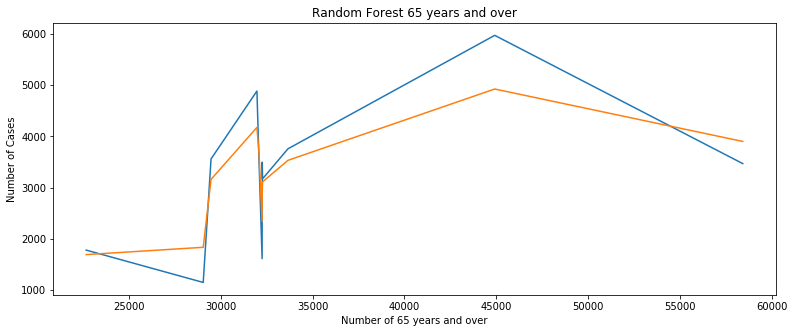

In [864]:
plt.figure(figsize=(8 * 1.618, 5))

X = [44922.5, 31971.6, 58433.7, 32089.4, 29472.4, 32261.4, 29046.2, 32253.1, 33659.9, 32276.7, 22670]
Y = CountiesTotalCases["9/9/20_x"].tolist() 
X.sort()
XT = np.reshape(X, (1, -1)).T
YT = np.reshape(Y, (1, -1)).T

# # Y = Y.reshape(-1, 1)
model = RandomForestRegressor()
model.fit(XT, YT)

# Plot the data and the model prediction
y_fit = model.predict(XT)

plt.plot(XT, YT)
plt.plot(XT, y_fit);
plt.title('Random Forest 65 years and over')
plt.xlabel('Number of 65 years and over')
plt.ylabel('Number of Cases')

C:\Users\sanam\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


Text(0, 0.5, 'Number of Cases')

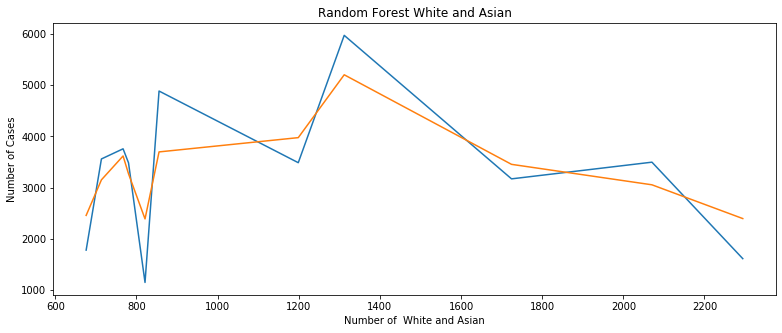

In [863]:
RaceWhite = TDF["Two or more races!!White and Asian"]
X=[]
for i in range(len(TDF["Two or more races!!White and Asian"])):
    X.append(TDF["Two or more races!!White and Asian"][i])
X.sort()
Y = [1778, 3559, 3757, 3483, 1146, 4886, 3486, 5974, 3170, 3496, 1611]
XT = np.reshape(X, (1, -1)).T
YT = np.reshape(Y, (1, -1)).T

model = RandomForestRegressor()
model.fit(XT, YT)

y_fit = model.predict(XT)

plt.figure(figsize=(8 * 1.618, 5))
plt.plot(XT, YT)
plt.plot(XT, y_fit);
plt.title('Random Forest White and Asian')
plt.xlabel('Number of  White and Asian')
plt.ylabel('Number of Cases')


C:\Users\sanam\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


Text(0, 0.5, 'Number of Cases')

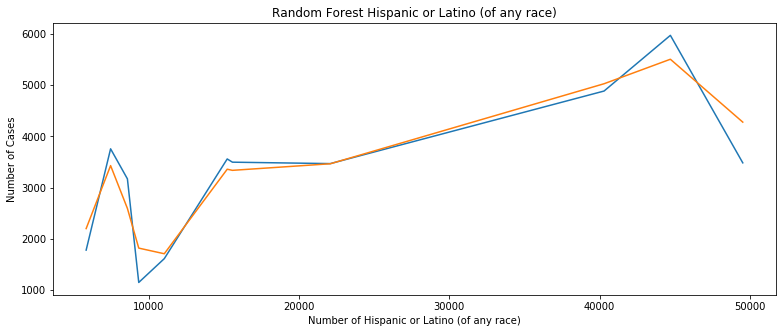

In [862]:
RaceWhite = TDF["Two or more races!!White and Asian"]
X=[]
for i in range(len(TDF["Hispanic or Latino (of any race)"])):
    X.append(TDF["Hispanic or Latino (of any race)"][i])
X.sort()
Y = [1778, 3757, 3170, 1146, 1611, 3559, 3496, 3468, 4886, 5974, 3483]
XT = np.reshape(X, (1, -1)).T
YT = np.reshape(Y, (1, -1)).T

model = RandomForestRegressor()
model.fit(XT, YT)

y_fit = model.predict(XT)

plt.figure(figsize=(8 * 1.618, 5))
plt.plot(XT, YT)
plt.plot(XT, y_fit);
plt.title('Random Forest Hispanic or Latino (of any race)')
plt.xlabel('Number of Hispanic or Latino (of any race)')
plt.ylabel('Number of Cases')


C:\Users\sanam\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


Text(0, 0.5, 'Number of Cases')

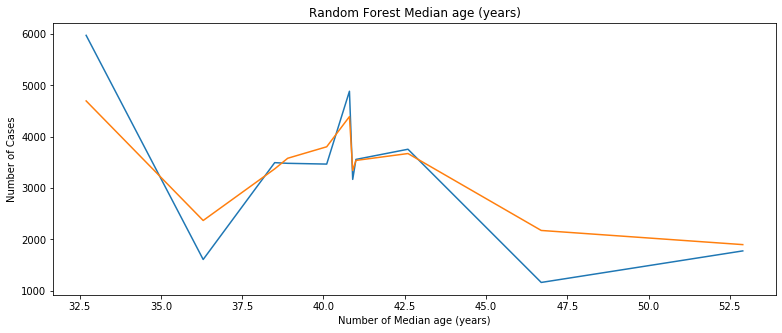

In [865]:
RaceWhite = TDF["Two or more races!!White and Asian"]
X=[]
for i in range(len(TDF["Median age (years)"])):
    X.append(TDF["Median age (years)"][i])
X.sort()
Y = [5974, 1611, 3496, 3483, 3468, 4886, 3170, 3559, 3757, 1164, 1778]
XT = np.reshape(X, (1, -1)).T
YT = np.reshape(Y, (1, -1)).T

model = RandomForestRegressor()
model.fit(XT, YT)

y_fit = model.predict(XT)

plt.figure(figsize=(8 * 1.618, 5))
plt.plot(XT, YT)
plt.plot(XT, y_fit);
plt.title('Random Forest Median age (years)')
plt.xlabel('Number of Median age (years)')
plt.ylabel('Number of Cases')

C:\Users\sanam\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


Text(0, 0.5, 'Number of Cases')

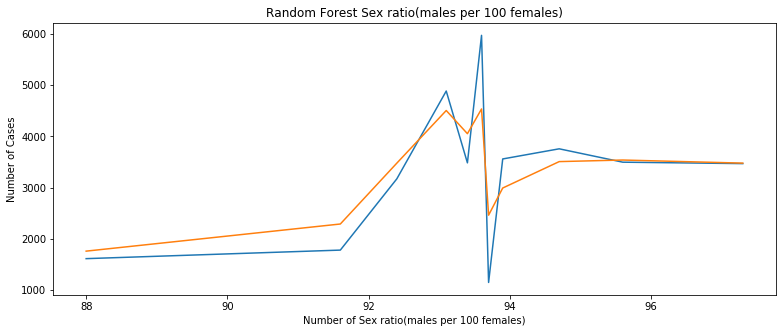

In [868]:
RaceWhite = TDF["Two or more races!!White and Asian"]
X=[]
for i in range(len(TDF["Sex ratio(males per 100 females)"])):
    X.append(TDF["Sex ratio(males per 100 females)"][i])
X.sort()
Y = [1611, 1778, 3170, 4886, 3483, 5974, 1146, 3559, 3757, 3496, 3468]
XT = np.reshape(X, (1, -1)).T
YT = np.reshape(Y, (1, -1)).T

model = RandomForestRegressor()
model.fit(XT, YT)

y_fit = model.predict(XT)

plt.figure(figsize=(8 * 1.618, 5))
plt.plot(XT, YT)
plt.plot(XT, y_fit);
plt.title('Random Forest Sex ratio(males per 100 females)')
plt.xlabel('Number of Sex ratio(males per 100 females)')
plt.ylabel('Number of Cases')

Text(0, 0.5, 'Number of Cases')

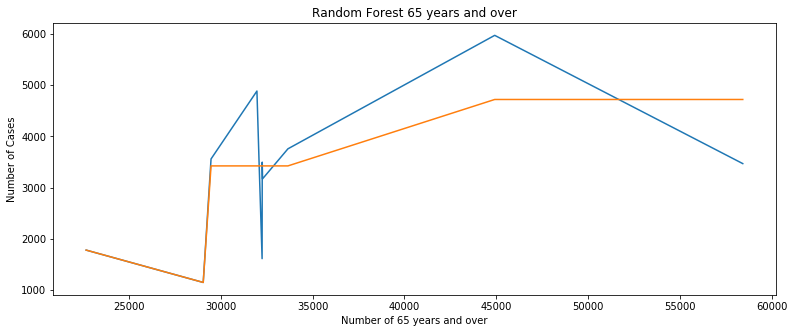

In [872]:
plt.figure(figsize=(8 * 1.618, 5))

X = [44922.5, 31971.6, 58433.7, 32089.4, 29472.4, 32261.4, 29046.2, 32253.1, 33659.9, 32276.7, 22670]
Y = CountiesTotalCases["9/9/20_x"].tolist() 
X.sort()
XT = np.reshape(X, (1, -1)).T
YT = np.reshape(Y, (1, -1)).T

# # Y = Y.reshape(-1, 1)
model = DecisionTreeRegressor(max_depth = 2)
model.fit(XT, YT)

# Plot the data and the model prediction
y_fit = model.predict(XT)

plt.plot(XT, YT)
plt.plot(XT, y_fit);
plt.title('Random Forest 65 years and over')
plt.xlabel('Number of 65 years and over')
plt.ylabel('Number of Cases')

Text(0, 0.5, 'Number of Cases')

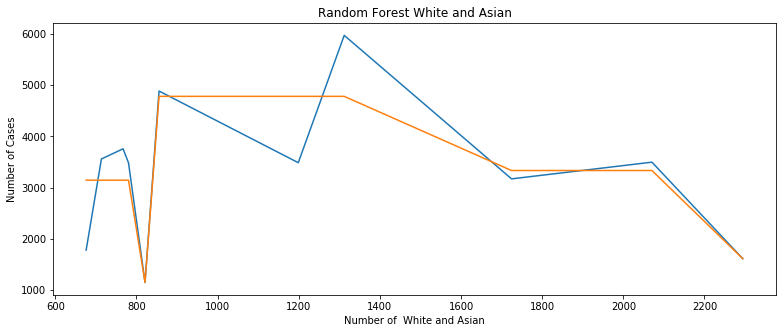

In [874]:
RaceWhite = TDF["Two or more races!!White and Asian"]
X=[]
for i in range(len(TDF["Two or more races!!White and Asian"])):
    X.append(TDF["Two or more races!!White and Asian"][i])
X.sort()
Y = [1778, 3559, 3757, 3483, 1146, 4886, 3486, 5974, 3170, 3496, 1611]
XT = np.reshape(X, (1, -1)).T
YT = np.reshape(Y, (1, -1)).T

model = DecisionTreeRegressor(max_depth = 3)
model.fit(XT, YT)

y_fit = model.predict(XT)

plt.figure(figsize=(8 * 1.618, 5))
plt.plot(XT, YT)
plt.plot(XT, y_fit);
plt.title('Random Forest White and Asian')
plt.xlabel('Number of  White and Asian')
plt.ylabel('Number of Cases')


Text(0, 0.5, 'Number of Cases')

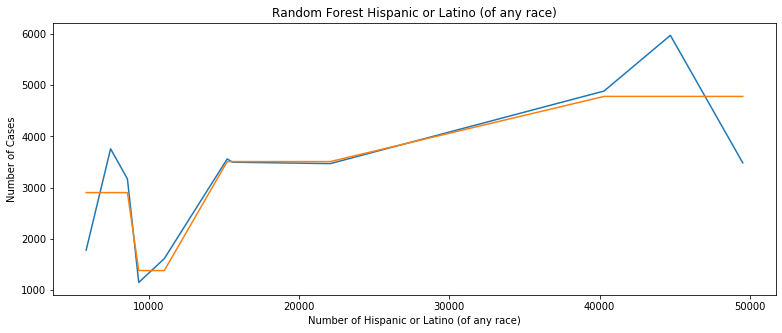

In [876]:
RaceWhite = TDF["Two or more races!!White and Asian"]
X=[]
for i in range(len(TDF["Hispanic or Latino (of any race)"])):
    X.append(TDF["Hispanic or Latino (of any race)"][i])
X.sort()
Y = [1778, 3757, 3170, 1146, 1611, 3559, 3496, 3468, 4886, 5974, 3483]
XT = np.reshape(X, (1, -1)).T
YT = np.reshape(Y, (1, -1)).T

model = DecisionTreeRegressor(max_depth = 2)
model.fit(XT, YT)

y_fit = model.predict(XT)

plt.figure(figsize=(8 * 1.618, 5))
plt.plot(XT, YT)
plt.plot(XT, y_fit);
plt.title('Random Forest Hispanic or Latino (of any race)')
plt.xlabel('Number of Hispanic or Latino (of any race)')
plt.ylabel('Number of Cases')


Text(0, 0.5, 'Number of Cases')

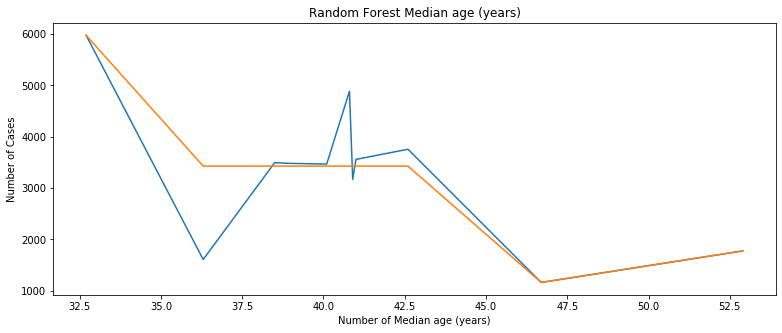

In [879]:
RaceWhite = TDF["Two or more races!!White and Asian"]
X=[]
for i in range(len(TDF["Median age (years)"])):
    X.append(TDF["Median age (years)"][i])
X.sort()
Y = [5974, 1611, 3496, 3483, 3468, 4886, 3170, 3559, 3757, 1164, 1778]
XT = np.reshape(X, (1, -1)).T
YT = np.reshape(Y, (1, -1)).T

model = DecisionTreeRegressor(max_depth = 2)
model.fit(XT, YT)

y_fit = model.predict(XT)

plt.figure(figsize=(8 * 1.618, 5))
plt.plot(XT, YT)
plt.plot(XT, y_fit);
plt.title('Random Forest Median age (years)')
plt.xlabel('Number of Median age (years)')
plt.ylabel('Number of Cases')

Text(0, 0.5, 'Number of Cases')

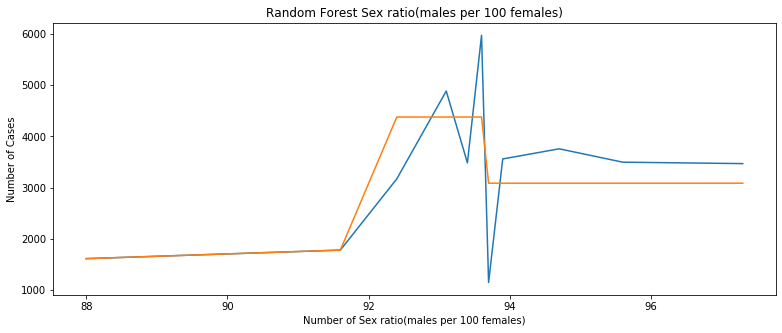

In [882]:
RaceWhite = TDF["Two or more races!!White and Asian"]
X=[]
for i in range(len(TDF["Sex ratio(males per 100 females)"])):
    X.append(TDF["Sex ratio(males per 100 females)"][i])
X.sort()
Y = [1611, 1778, 3170, 4886, 3483, 5974, 1146, 3559, 3757, 3496, 3468]
XT = np.reshape(X, (1, -1)).T
YT = np.reshape(Y, (1, -1)).T

model = DecisionTreeRegressor(max_depth = 2)
model.fit(XT, YT)

y_fit = model.predict(XT)

plt.figure(figsize=(8 * 1.618, 5))
plt.plot(XT, YT)
plt.plot(XT, y_fit);
plt.title('Random Forest Sex ratio(males per 100 females)')
plt.xlabel('Number of Sex ratio(males per 100 females)')
plt.ylabel('Number of Cases')

### Deaths

C:\Users\sanam\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


Text(0, 0.5, 'Number of Deaths')

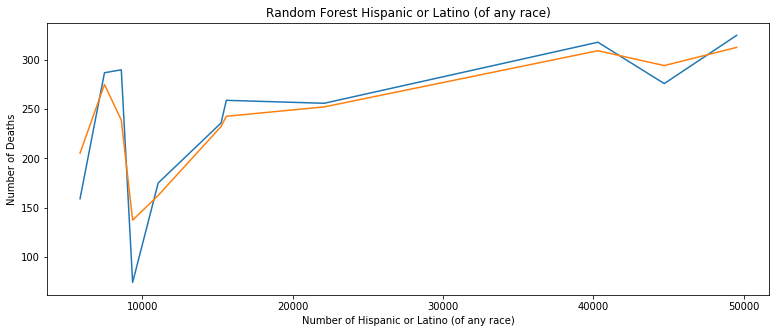

In [888]:
RaceWhite = TDF["Two or more races!!White and Asian"]
X=[]
for i in range(len(TDF["Hispanic or Latino (of any race)"])):
    X.append(TDF["Hispanic or Latino (of any race)"][i])
X.sort()
Y = [159, 287, 290, 74, 175, 236, 259, 256, 318, 276, 325]
XT = np.reshape(X, (1, -1)).T
YT = np.reshape(Y, (1, -1)).T

model = RandomForestRegressor()
model.fit(XT, YT)

y_fit = model.predict(XT)

plt.figure(figsize=(8 * 1.618, 5))
plt.plot(XT, YT)
plt.plot(XT, y_fit);
plt.title('Random Forest Hispanic or Latino (of any race)')
plt.xlabel('Number of Hispanic or Latino (of any race)')
plt.ylabel('Number of Deaths')


C:\Users\sanam\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


Text(0, 0.5, 'Number of Deaths')

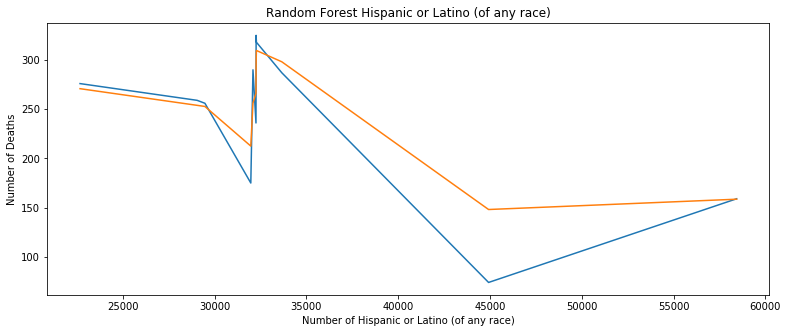

In [896]:
RaceWhite = TDF["Two or more races!!White and Asian"]
X=[]
for i in range(len(TDF["65 years and over"])):
    X.append(TDF["65 years and over"][i])
X.sort()
Y = [276, 259, 256, 175, 290, 236, 325, 318, 287, 74, 159]
XT = np.reshape(X, (1, -1)).T
YT = np.reshape(Y, (1, -1)).T

model = RandomForestRegressor()
model.fit(XT, YT)

y_fit = model.predict(XT)

plt.figure(figsize=(8 * 1.618, 5))
plt.plot(XT, YT)
plt.plot(XT, y_fit);
plt.title('Random Forest Hispanic or Latino (of any race)')
plt.xlabel('Number of Hispanic or Latino (of any race)')
plt.ylabel('Number of Deaths')


C:\Users\sanam\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


Text(0, 0.5, 'Number of Deaths')

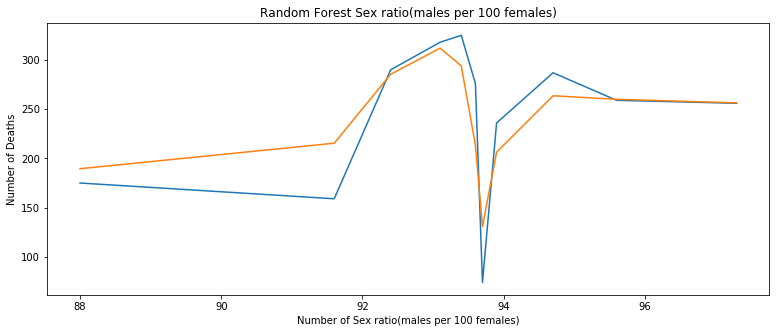

In [902]:
RaceWhite = TDF["Two or more races!!White and Asian"]
X=[]
for i in range(len(TDF["Sex ratio(males per 100 females)"])):
    X.append(TDF["Sex ratio(males per 100 females)"][i])
X.sort()
Y = [175, 159, 290, 318, 325, 276, 74, 236, 287, 259, 256]
XT = np.reshape(X, (1, -1)).T
YT = np.reshape(Y, (1, -1)).T

model = RandomForestRegressor()
model.fit(XT, YT)

y_fit = model.predict(XT)

plt.figure(figsize=(8 * 1.618, 5))
plt.plot(XT, YT)
plt.plot(XT, y_fit);
plt.title('Random Forest Sex ratio(males per 100 females)')
plt.xlabel('Number of Sex ratio(males per 100 females)')
plt.ylabel('Number of Deaths')

C:\Users\sanam\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


Text(0, 0.5, 'Number of Deaths')

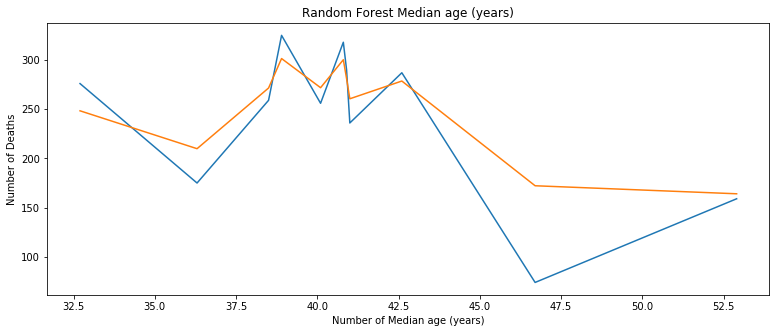

In [906]:
RaceWhite = TDF["Two or more races!!White and Asian"]
X=[]
for i in range(len(TDF["Median age (years)"])):
    X.append(TDF["Median age (years)"][i])
X.sort()
Y = [276, 175, 259, 325, 256, 318, 290, 236, 287, 74, 159]
XT = np.reshape(X, (1, -1)).T
YT = np.reshape(Y, (1, -1)).T

model = RandomForestRegressor()
model.fit(XT, YT)

y_fit = model.predict(XT)

plt.figure(figsize=(8 * 1.618, 5))
plt.plot(XT, YT)
plt.plot(XT, y_fit);
plt.title('Random Forest Median age (years)')
plt.xlabel('Number of Median age (years)')
plt.ylabel('Number of Deaths')